# Perumusan Masalah

Seiring dengan berjalannya waktu dan makin ketatnya persaingan usaha E-Commerce, mempertahankan pelanggan untuk tetap menggunakan platform perusahaan bukanlah hal yang bisa dianggap mudah. Salah satu caranya adalah dengan membuat promosi, dan layanan-layanan yang membuat pelanggan semakin senang dan tertarik untuk menggunakan platform kita.

Namun disatu sisi, anggaran promosi pada target costumer yang tidak tepat hanya akan membuat perusahaan merugi atau keuntungan yang tidak signifikan. Oleh karena itu, dibutuhkan algoritma machine learning yang akan bisa memprediksi customer yang berpotensi Churn, agar bisa menargetkan mereka (pelanggan berpotensi churn) untuk sasaran promosi yang bisa membuat mereka tidak jadi meninggalkan layanan pembelian.

Outline:

1. Data Understanding
2. Data Cleaning
    * Duplicate Value
    * Missing Value
    * Outliers
3. Exploratory Data Analysis
    * Multicolinearity Check
    * Churn vs No Churn
    * Tenure
    * Cashback Amount
4. Data Preprocessing
5. Data Splitting
    * Train & Test Split
6. Model & Evaluation
    * Benchmark Model Data w/ Outliers
    * Benchmark Model Data wo/ Outliers
    * Handling Imbalance
7. Hyperparameter Tuning
    * Perbandingan Sebelum dan Sesudah Tuning
8. Feature Importance Insight
9. Conclusion & Recommendation

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings("ignore")

import category_encoders as ce
from sklearn.preprocessing import RobustScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, RandomizedSearchCV, KFold
from sklearn.metrics import confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report, confusion_matrix, recall_score, roc_curve
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.calibration import calibration_curve 
from sklearn.metrics import brier_score_loss

Dataset ini berisi:

| No.  | Fitur                  | Deskripsi                                            |
|------|------------------------|------------------------------------------------------|
| 1    | Tenure                 | Masa langganan                                       |
| 2    | WarehouseToHome        | Jarak dari gudang ke rumah pelanggan                |
| 3    | NumberOfDeviceRegistered | Total gadget yang terdaftar pada akun pelanggan   |
| 4    | PreferedOrderCat       | Kategori pesanan yang diorder oleh pelanggan bulan lalu |
| 5    | SatisfactionScore      | Tingkat kepuasan pelanggan                          |
| 6    | MaritalStatus          | Status pernikahan pelanggan                         |
| 7    | NumberOfAddress        | Jumlah alamat yang didaftarkan oleh pelanggan       |
| 8    | Complaint              | Penanda apakah ada komplain dari pelanggan         |
| 9    | DaySinceLastOrder      | Jumlah hari sejak pemesanan terakhir               |
| 10   | CashbackAmount         | Rata-rata cashback yang didapatkan oleh pelanggan   |
| 11   | Churn                  | Penanda churn                                       |



In [2]:
# Load Dataset
df=pd.read_csv('data_ecommerce_customer_churn.csv')
df

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
...,...,...,...,...,...,...,...,...,...,...,...
3936,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3937,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0
3938,30.0,6.0,5,Laptop & Accessory,3,Married,3,1,2.0,156.60,0
3939,6.0,NaN,4,Mobile,3,Married,10,1,0.0,124.37,1


# Data Understanding

In [3]:
# Melihat data unik di tiap kolom
listItem = []
for col in df.columns :
    listItem.append( [col,
                      df[col].dtype, 
                      df[col].isna().sum(), 
                      round((df[col].isna().sum()/len(df[col]))*100, 2),
                      df[col].nunique(), 
                      df[col].unique()])

desc_table = pd.DataFrame(columns=['Column Name',
                                   'Data Type',
                                   'Null Values Sum',
                                    'Null Percent',
                                    'Number of Unique',
                                    'Unique Sample'],
                        data=listItem)
desc_table

,Column Name,Data Type,Null Values Sum,Null Percent,Number of Unique,Unique Sample
0,Tenure,float64,194,4.92,36,"[15.0, 7.0, 27.0, 20.0, 30.0, 1.0, 11.0, 17.0,..."
1,WarehouseToHome,float64,169,4.29,33,"[29.0, 25.0, 13.0, 15.0, 16.0, 11.0, 12.0, 7.0..."
2,NumberOfDeviceRegistered,int64,0,0.00,6,"[4, 3, 6, 2, 5, 1]"
3,PreferedOrderCat,object,0,0.00,6,"[Laptop & Accessory, Mobile, Fashion, Others, ..."
4,SatisfactionScore,int64,0,0.00,5,"[3, 1, 4, 2, 5]"
5,MaritalStatus,object,0,0.00,3,"[Single, Married, Divorced]"
6,NumberOfAddress,int64,0,0.00,14,"[2, 5, 7, 8, 3, 1, 9, 4, 10, 11, 6, 19, 22, 21]"
7,Complain,int64,0,0.00,2,"[0, 1]"
8,DaySinceLastOrder,float64,213,5.40,22,"[7.0, nan, 8.0, 11.0, 2.0, 1.0, 4.0, 3.0, 6.0,..."
9,CashbackAmount,float64,0,0.00,2335,"[143.32, 129.29, 168.54, 230.27, 322.17, 152.8..."


In [4]:
display(df.describe(include='number').round(2))
display(df.describe(include='object'))

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
count,3747.00,3772.00,3941.00,3941.00,3941.00,3941.00,3728.00,3941.00,3941.00
mean,10.08,15.65,3.68,3.09,4.24,0.28,4.53,176.71,0.17
std,8.50,8.45,1.01,1.38,2.63,0.45,3.67,48.79,0.38
min,0.00,5.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00
25%,2.00,9.00,3.00,2.00,2.00,0.00,2.00,145.70,0.00
50%,9.00,14.00,4.00,3.00,3.00,0.00,3.00,163.34,0.00
75%,16.00,21.00,4.00,4.00,6.00,1.00,7.00,195.25,0.00
max,61.00,127.00,6.00,5.00,22.00,1.00,46.00,324.99,1.00


,PreferedOrderCat,MaritalStatus
count,3941,3941
unique,6,3
top,Laptop & Accessory,Married
freq,1458,2055


Dari tabel diatas dapat kita ketahui bahwa:
1. Terdapat Missing Values pada kolom `Tenure`, `WarehouseToHome`, dan `DaySinceLastOrder`
2. Pada kolom `PreferedOrderCat` dapat kita lihat bahwa terdapa value yang sebenernya sama, tapi penulisannya berbeda, yaitu **Mobile Phone** dan **Mobile**
3. Pada kolom `MaritalStatus` **Divorced** dapat kita anggap sebagai **Single**, sehingga variabel **Divorced** akan saya ubah.
4. Diduga terdapat Outliers pada kolom `Tenure`, `WarehouseToHome`, `NumberOfAddress`, dan `DaySinceLastOrder` karena nilainya melebihi nilai batas atas yang telah ditetapkan berdasarkan metode IQR pada masing-masing kolomnya.

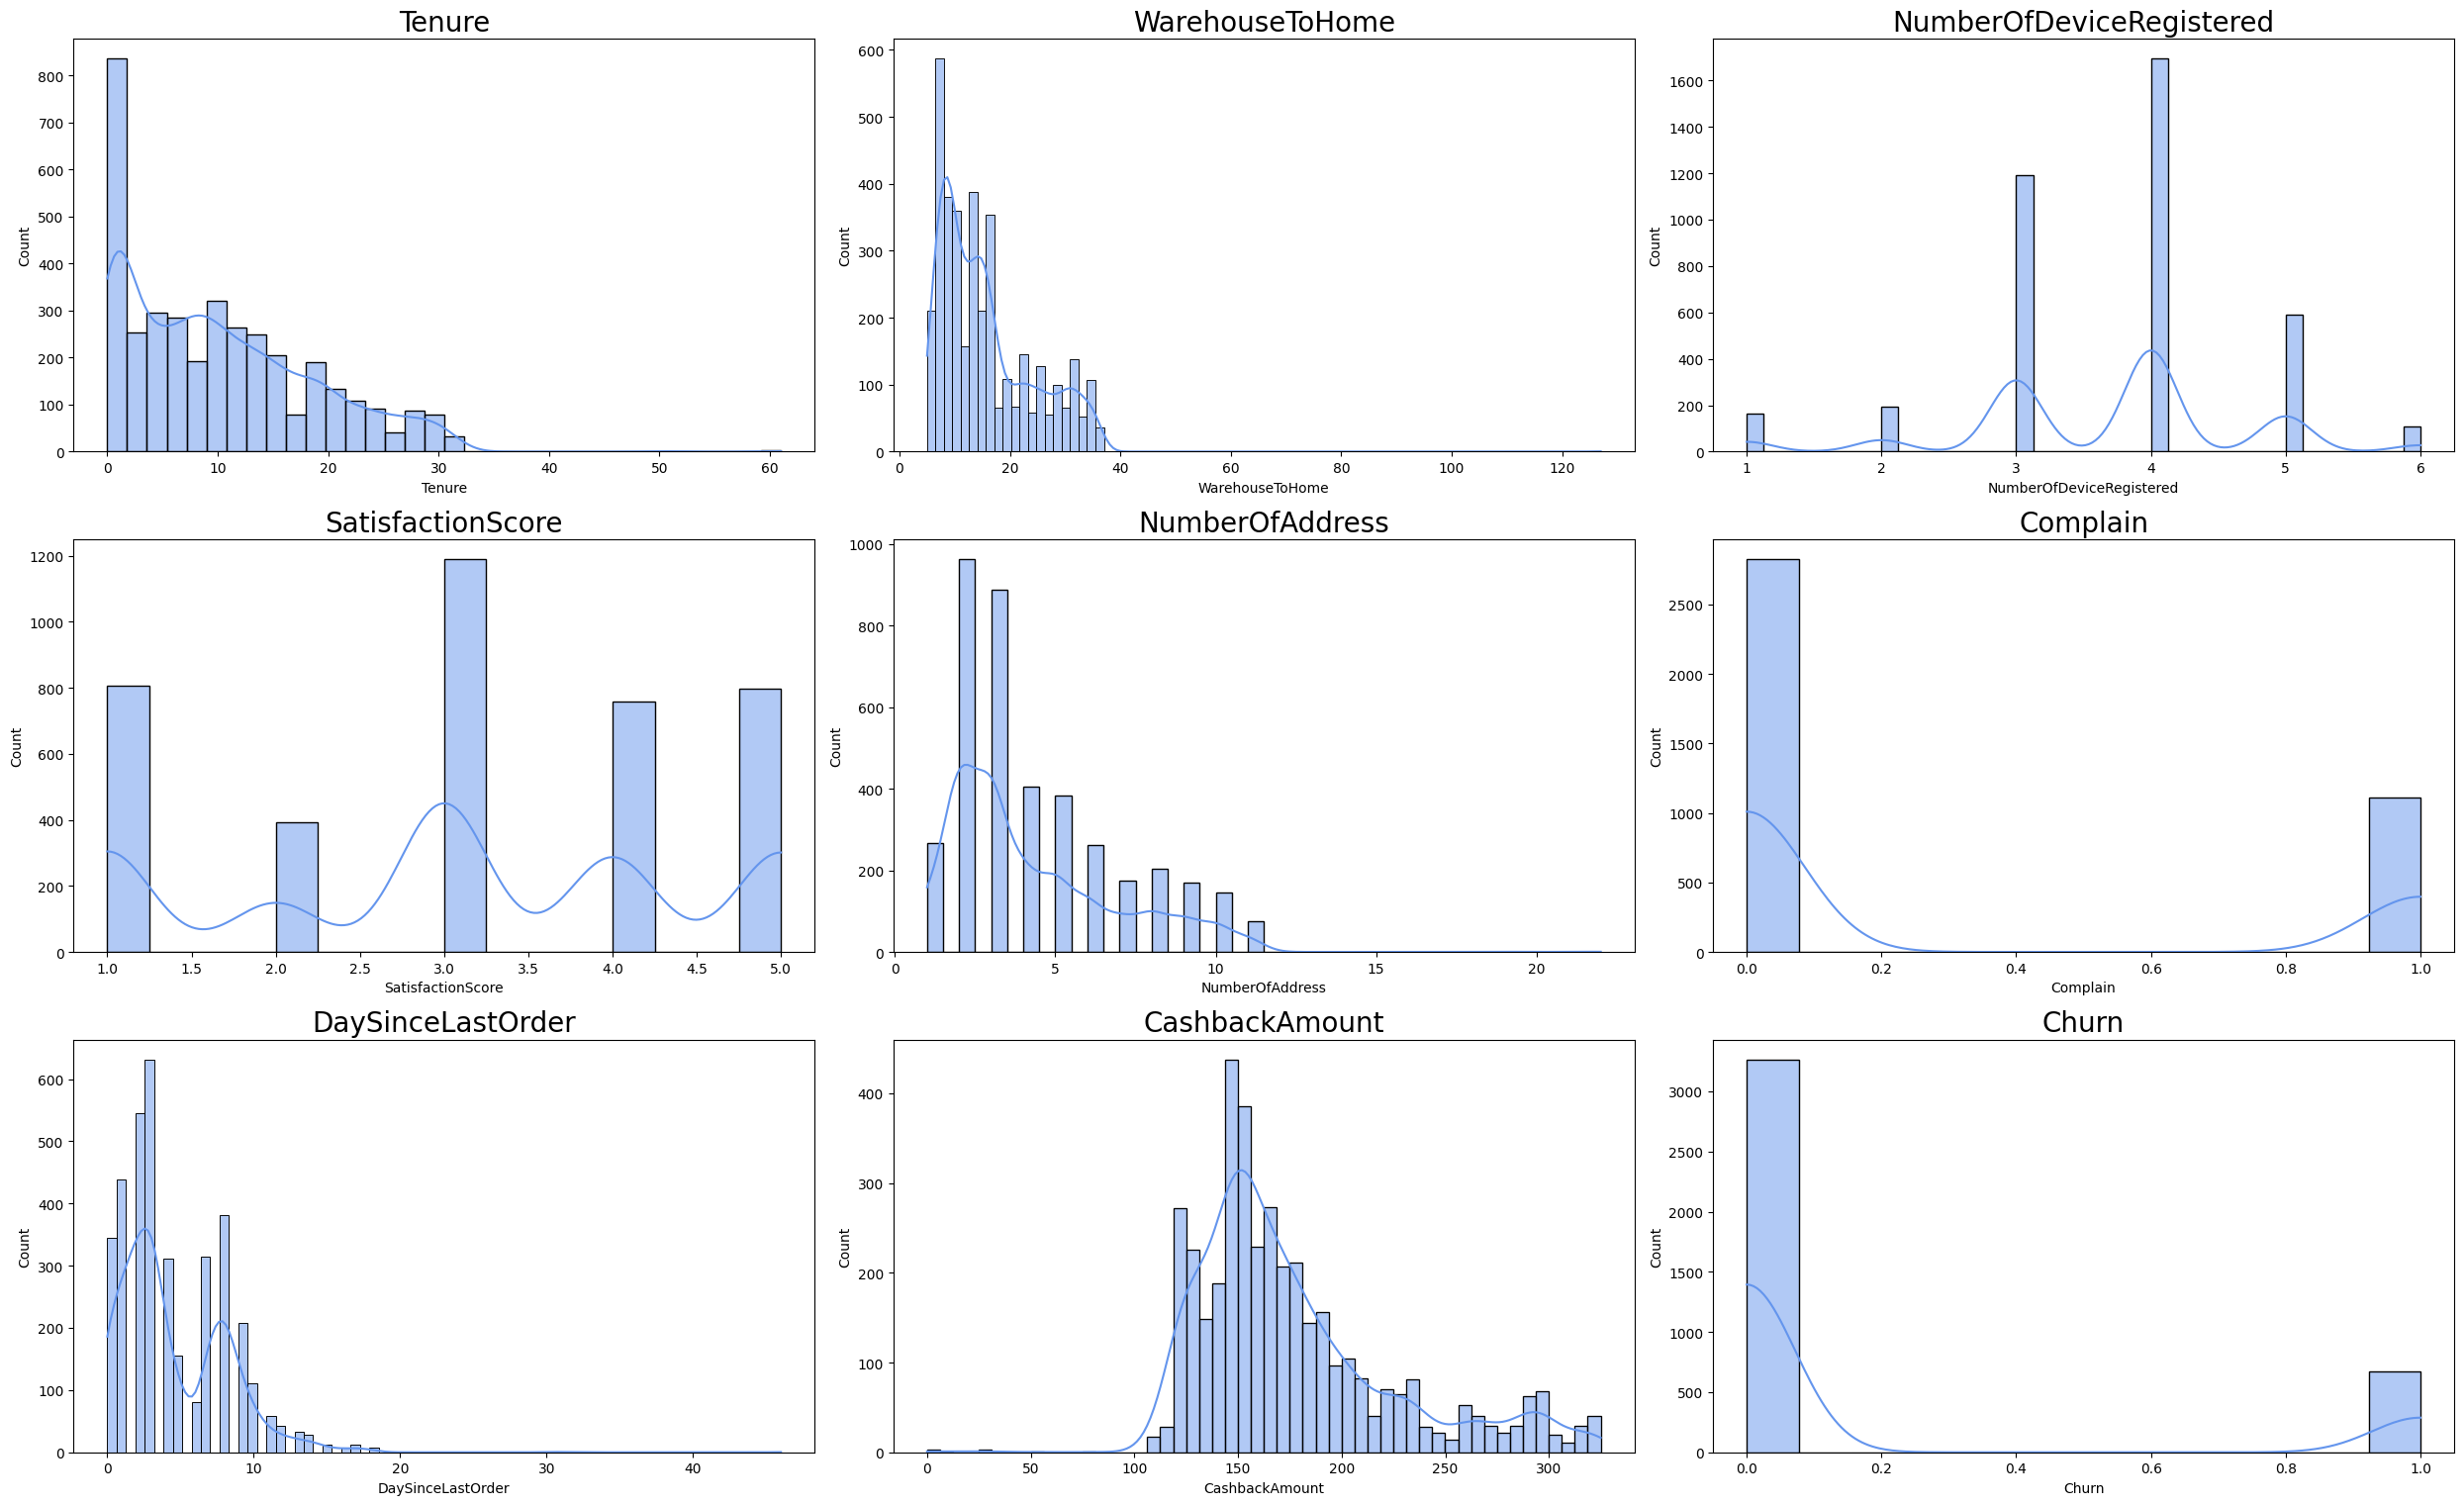

In [5]:
# Melihat sebaran data kolom numerik
plt.figure(figsize=(25, 25))
plotnumber = 1
num_features = df.select_dtypes(include='number').columns

for feature in num_features:
    ax = plt.subplot(5, 3, plotnumber)
    sns.histplot(data=df,x=feature,color='cornflowerblue',kde=True)
    plt.title(feature, fontsize=20)
    plotnumber += 1
    plt.tight_layout()

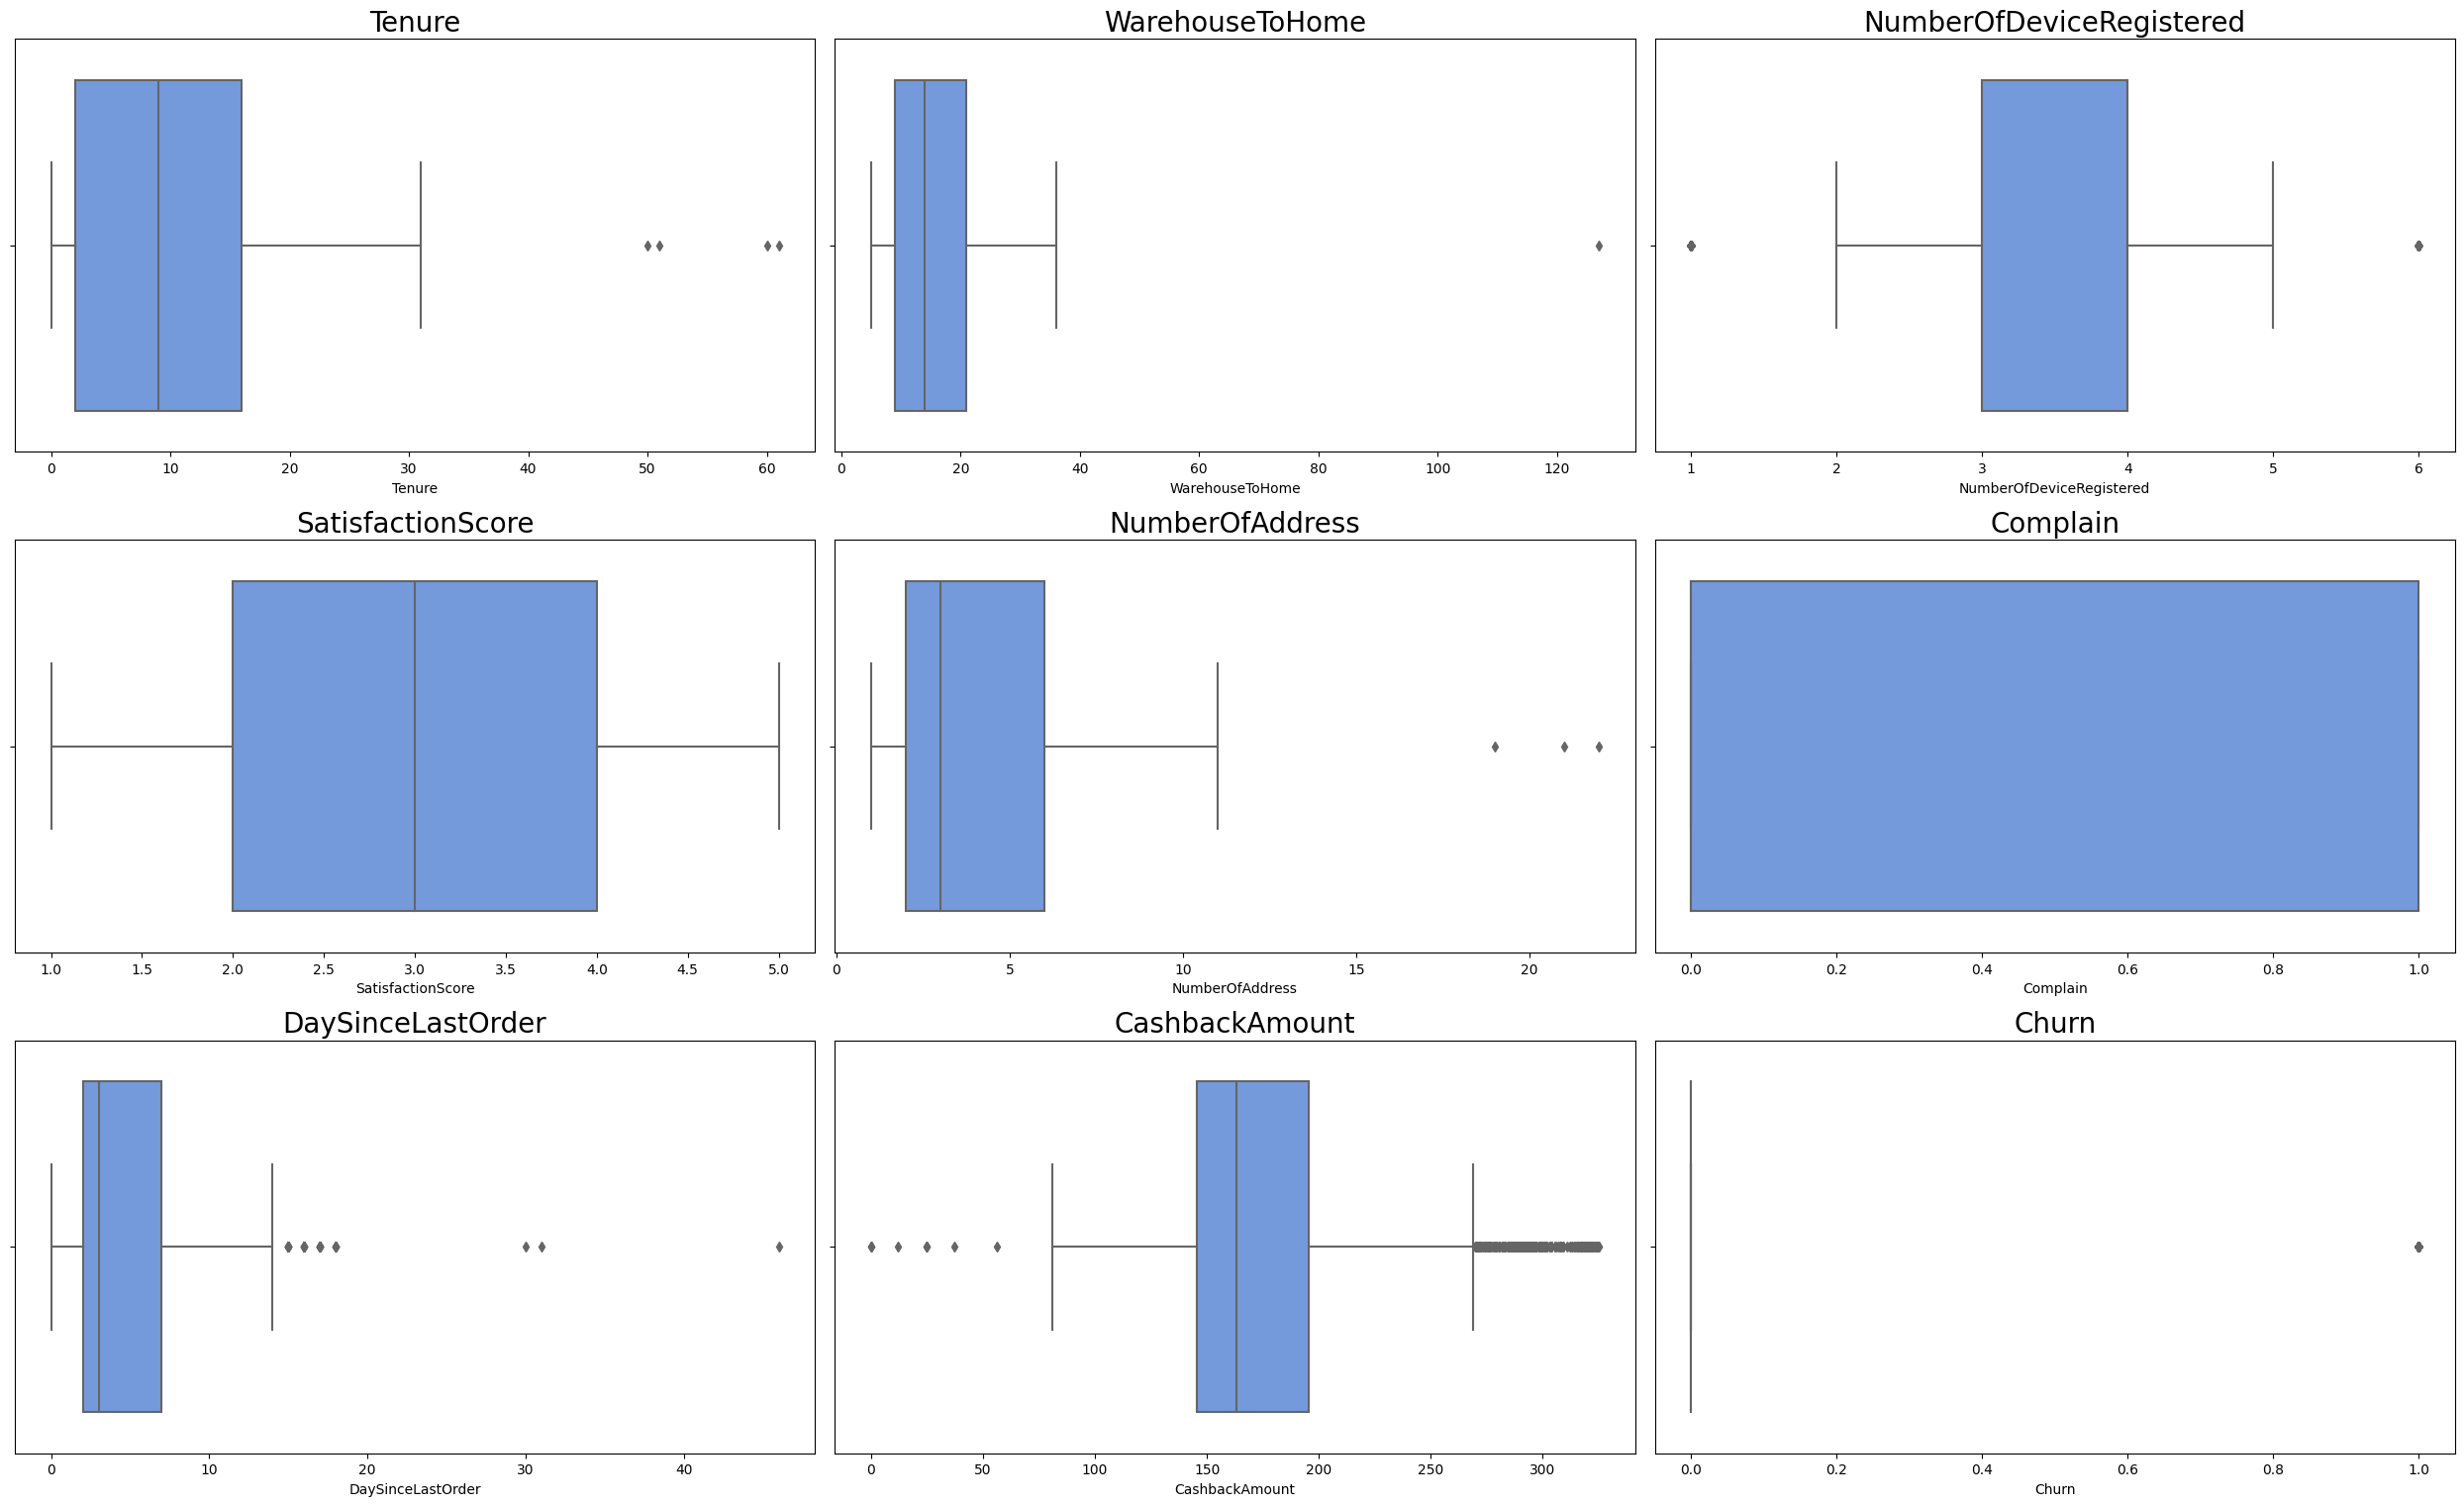

In [6]:
plt.figure(figsize=(25, 25))
plotnumber = 1
num_features = df.select_dtypes(include='number').columns

for feature in num_features:
    ax = plt.subplot(5, 3, plotnumber)
    sns.boxplot(data=df,x=feature,color='cornflowerblue')
    plt.title(feature, fontsize=20)
    plotnumber += 1
    plt.tight_layout()

Visualisasi sebaran data kolom numerik di atas memperkuat dugaan saya tentang adanya outliers pada kolom `Tenure`, `WarehouseToHome`, `NumberOfAddress`, dan `DaySinceLastOrder` karena sebaran grafiknya menunjukkan skew positif, hal tersebut mungkin butuh penanganan lebih lanjut.

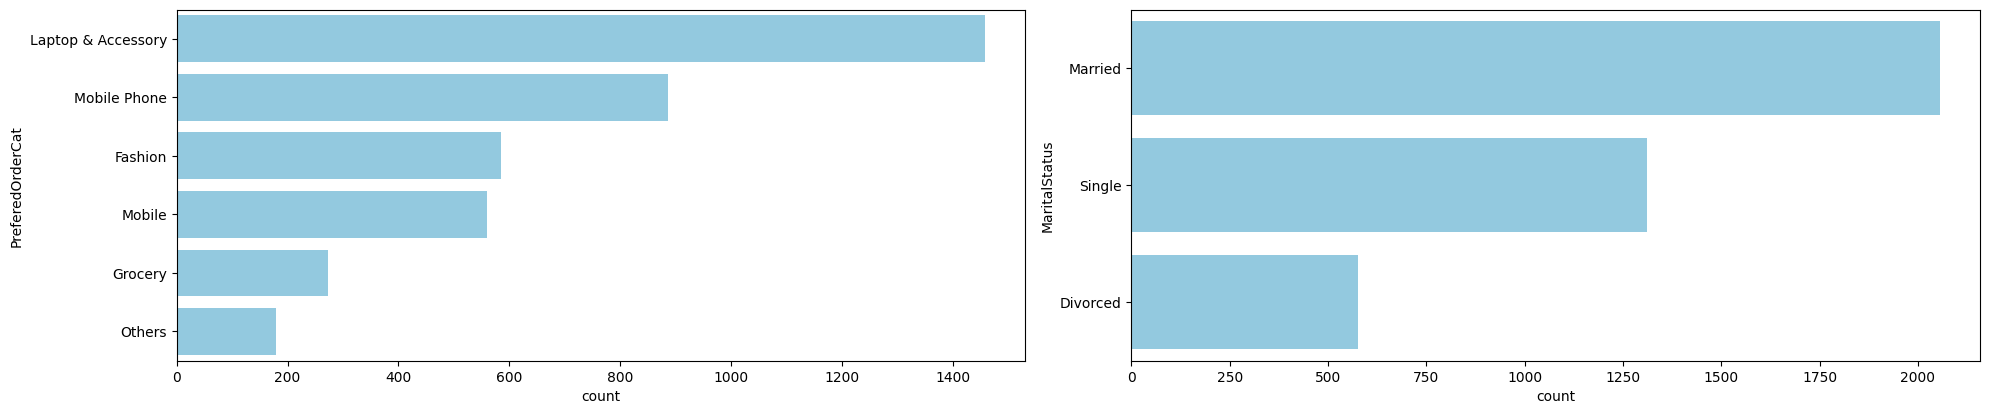

In [7]:
# Sebaran Data Kategorik
kategorik = df.select_dtypes(include='object')
count = 0
fig = plt.figure(figsize=(20,12))
for kolom in df.select_dtypes(include='object').columns:
    count += 1
    plt.subplot(3,2,count)
    sns.countplot(y = kolom, data = kategorik, order = kategorik[kolom].value_counts().sort_values(ascending = False).head(10).index, color= 'skyblue')
    fig.tight_layout()
plt.show()

# Data Cleaning

## Duplicate Value

Sebagaimana yang telah disampaikan di data understanding, bahwa terdapat variabel kategorik pada kolom `PreferedOrderCat` yang serupa tapi penulisannya tidak sama. kita akan rubah terlebih dahulu variabelnya.

In [8]:
# Mengcopy Data Set Baru
df2 = df.copy()


In [9]:
# Mengubah Value 'Mobile' menjadi 'Mobile Phone'
df2.loc[df2['PreferedOrderCat']=='Mobile','PreferedOrderCat'] = 'Mobile Phone'

In [10]:
df2['PreferedOrderCat'].unique()

array(['Laptop & Accessory', 'Mobile Phone', 'Fashion', 'Others',
       'Grocery'], dtype=object)

In [11]:
df2['MaritalStatus'].unique()

array(['Single', 'Married', 'Divorced'], dtype=object)

In [12]:
# Cek jumlah baris data yang memiliki nilai sama
df2.duplicated().sum()

672

In [13]:
# Drop data duplikat
df2.drop_duplicates(inplace=True)
df2.duplicated().sum()

0

In [14]:
df2

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile Phone,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
...,...,...,...,...,...,...,...,...,...,...,...
3933,25.0,15.0,5,Fashion,4,Married,7,0,8.0,249.90,0
3935,26.0,7.0,4,Grocery,1,Married,4,0,9.0,295.99,0
3936,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3937,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0


## Missing Values

<Axes: >

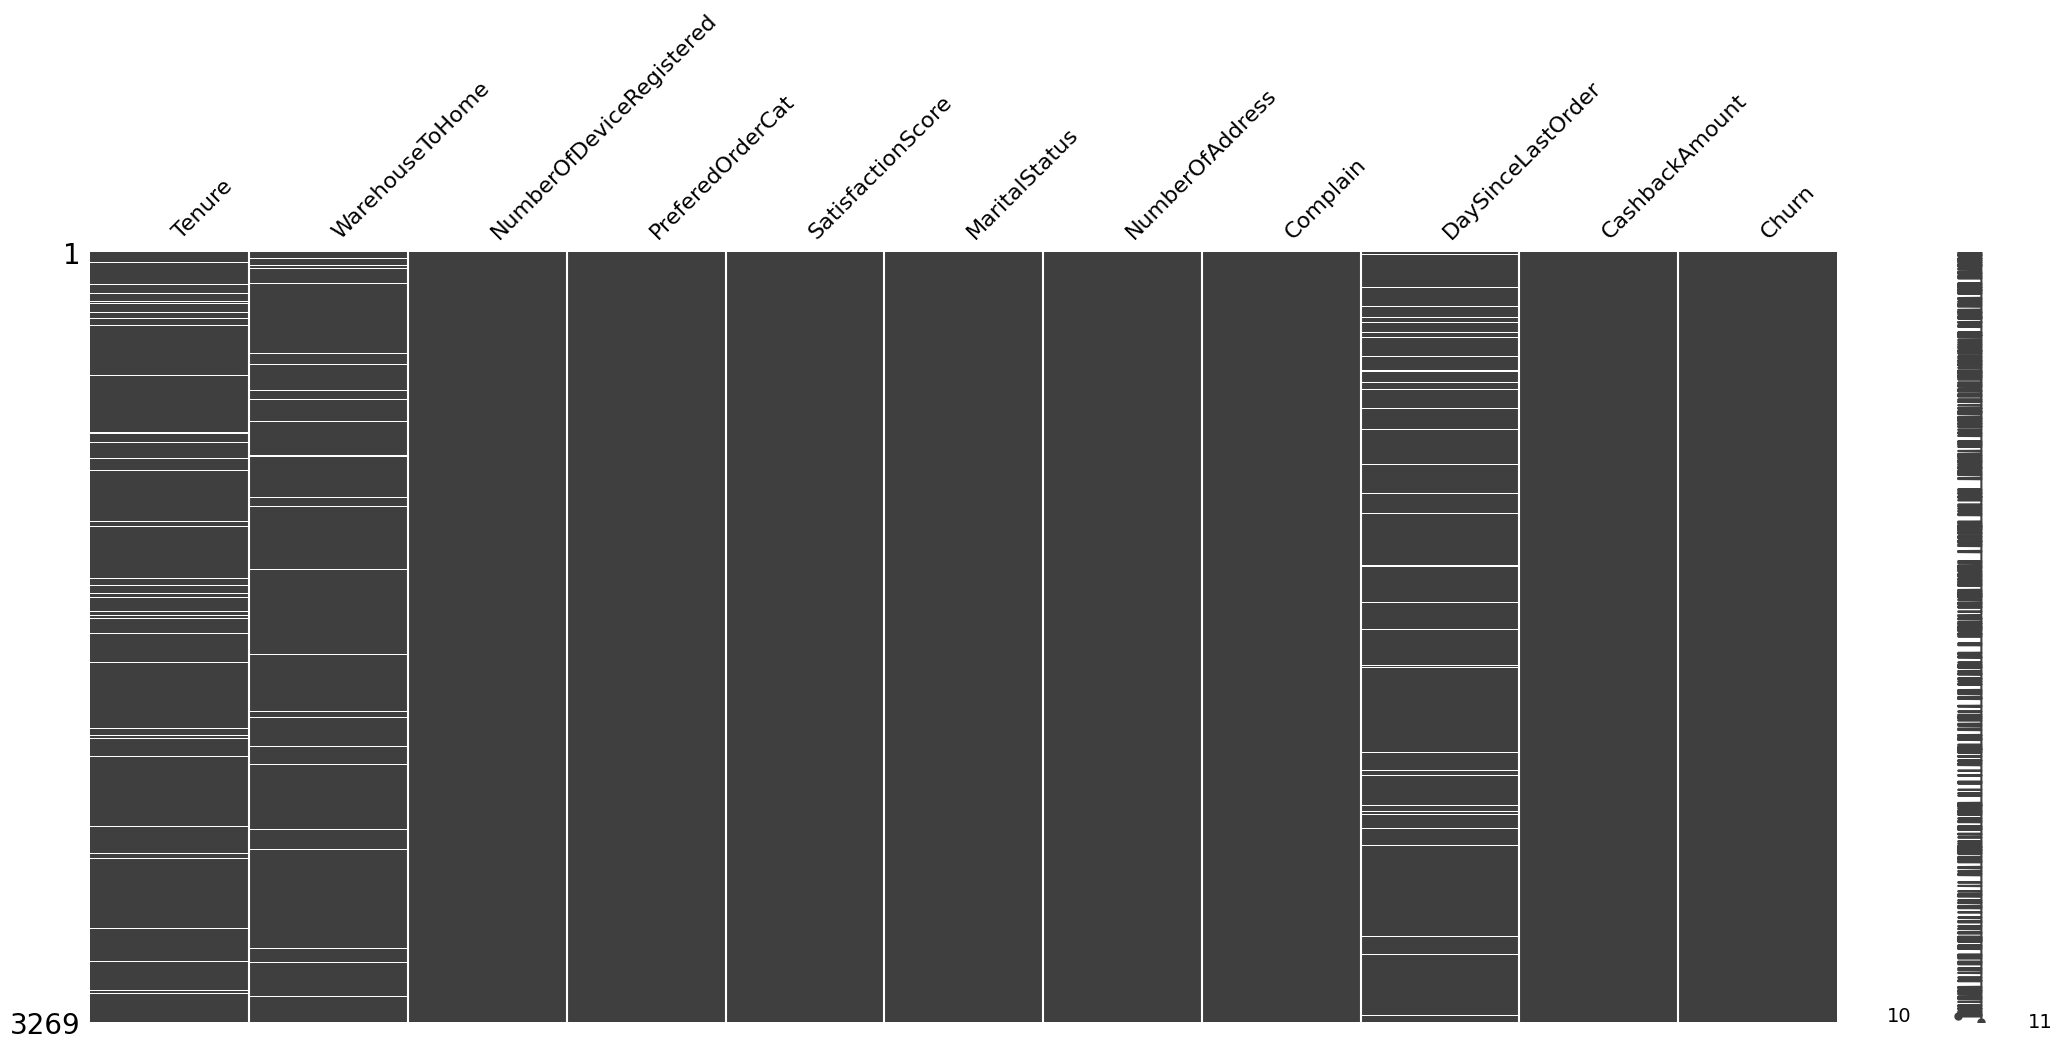

In [15]:
import missingno as mn

df3 = df2.copy()
mn.matrix(df3)

In [16]:
df3[['Tenure', 'WarehouseToHome', 'DaySinceLastOrder']].isna().sum()

Tenure               159
WarehouseToHome      135
DaySinceLastOrder    181
dtype: int64

Dapat kita lihat bahwa pada dataset ini jenis Missing Valuesnya adalah MAR atau Missing at Random. Oleh karena hal tersebut, saya akan mengisi missing values tersebut dengan Imputer. Dalam hal ini, saya akan menggunakan strategi **Iterative Imputer** pada saat Data Preprocessing

In [17]:
# Membuat iterative imputer
knn = KNNImputer()
df3[['Tenure', 'WarehouseToHome', 'DaySinceLastOrder']]=knn.fit_transform(df3[['Tenure', 'WarehouseToHome', 'DaySinceLastOrder']])

## Outlier

Telah kita ketahui berdasarkan metode IQR, bahwa terdapat outliers pada kolom `Tenure`, `WarehouseToHome`, `NumberOfAddress`, dan `DaySinceLastOrder`. Oleh karena itu, kita akan drop data pada kolom tersebut yang memiliki nilai di atas batas atas.

In [18]:
#Fungsi untuk menghapus data pada kolom yang memiliki outliers
def remove_outliers(data, col, k=1.5):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3-Q1
    upper_bound = Q3 + k * IQR

    data_cleaned = data[data[col]<=upper_bound]

    return data_cleaned

In [19]:
df4 = remove_outliers(df3, 'Tenure', k=1.5)
df4 = remove_outliers(df4, 'WarehouseToHome', k=1.5)
df4 = remove_outliers(df4, 'NumberOfAddress', k=1.5)
df4 = remove_outliers(df4, 'DaySinceLastOrder', k=1.5)

In [20]:
df3 = df3.reset_index(drop=True)
df4 = df4.reset_index(drop=True)

In [21]:
df3

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile Phone,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,2.2,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
...,...,...,...,...,...,...,...,...,...,...,...
3264,25.0,15.0,5,Fashion,4,Married,7,0,8.0,249.90,0
3265,26.0,7.0,4,Grocery,1,Married,4,0,9.0,295.99,0
3266,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3267,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0


In [22]:
df4

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile Phone,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,2.2,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
...,...,...,...,...,...,...,...,...,...,...,...
3216,25.0,15.0,5,Fashion,4,Married,7,0,8.0,249.90,0
3217,26.0,7.0,4,Grocery,1,Married,4,0,9.0,295.99,0
3218,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3219,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0


Text(0.5, 0, 'Filtered Tenure')

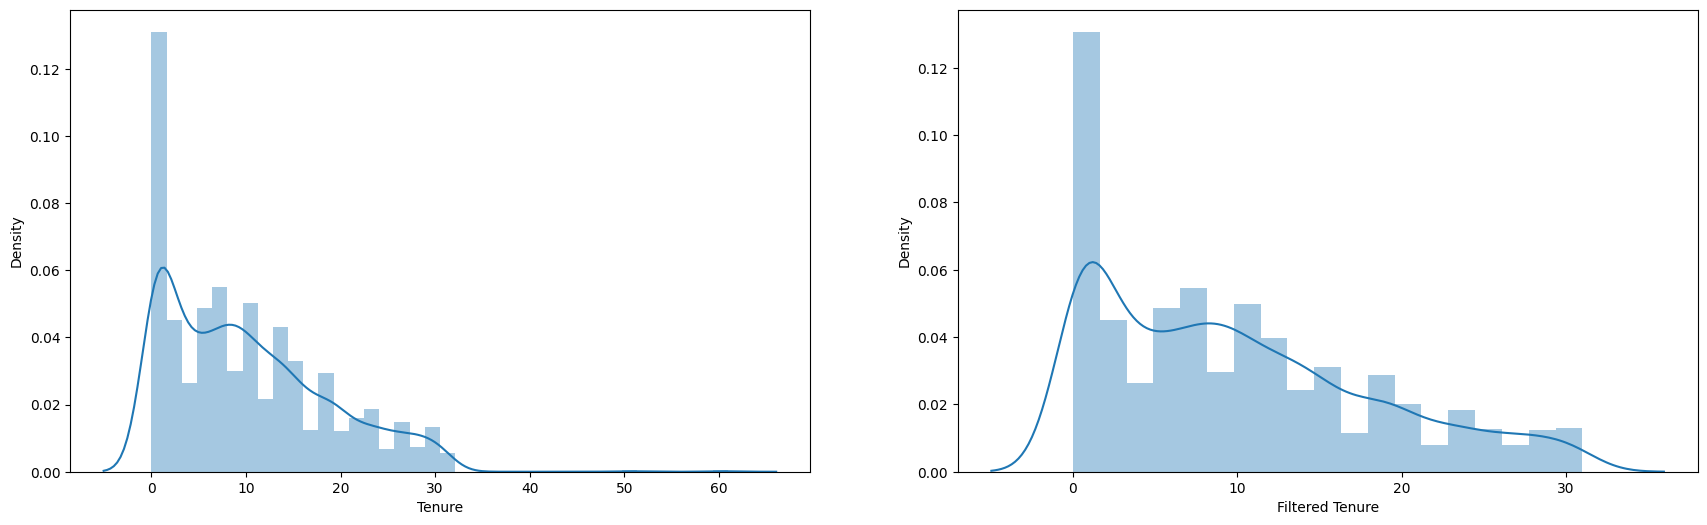

In [23]:
# Plot distribusi data sebelum dan sesudah filtering
fig, axes = plt.subplots(1,2, figsize=(21, 6))
sns.distplot(df3['Tenure'], ax=axes[0])
sns.distplot(df4['Tenure'], ax=axes[1])
axes[0].set_xlabel('Tenure')
axes[1].set_xlabel('Filtered Tenure')

Text(0.5, 0, 'Filtered Warehouse Distance')

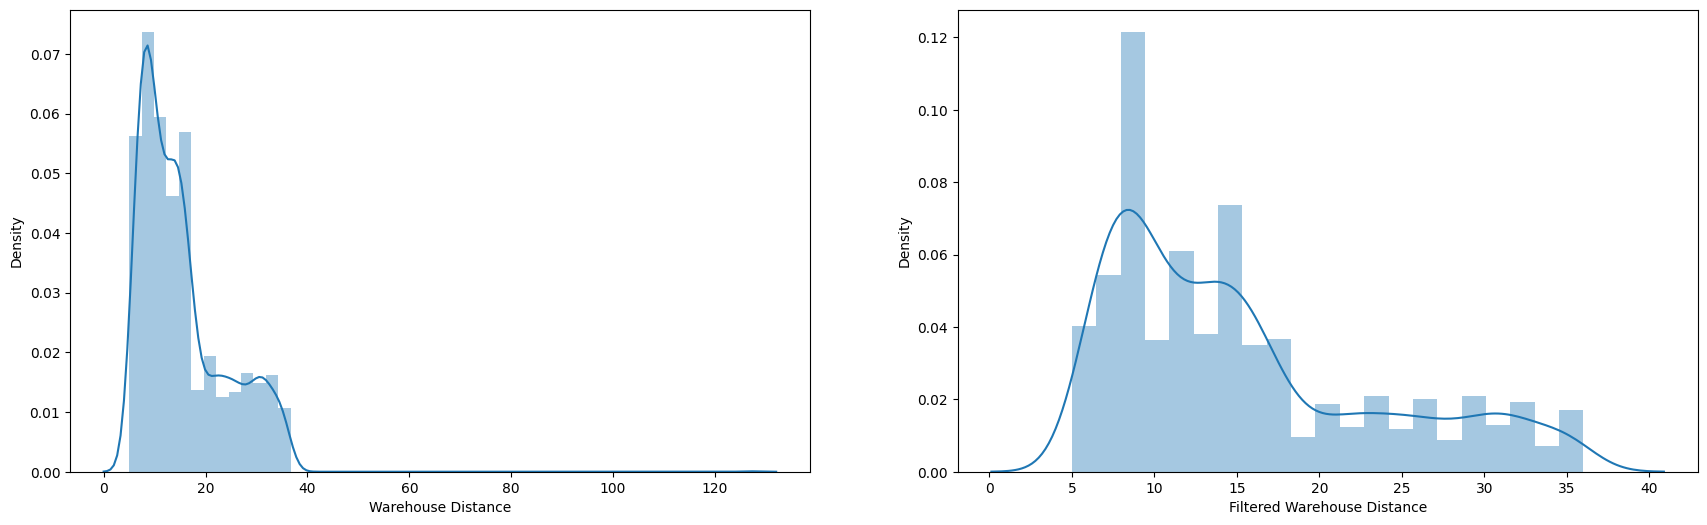

In [24]:
fig, axes = plt.subplots(1,2, figsize=(21, 6))
sns.distplot(df3['WarehouseToHome'], ax=axes[0])
sns.distplot(df4['WarehouseToHome'], ax=axes[1])
axes[0].set_xlabel('Warehouse Distance')
axes[1].set_xlabel('Filtered Warehouse Distance')

Text(0.5, 0, 'Filtered Address Registered Total')

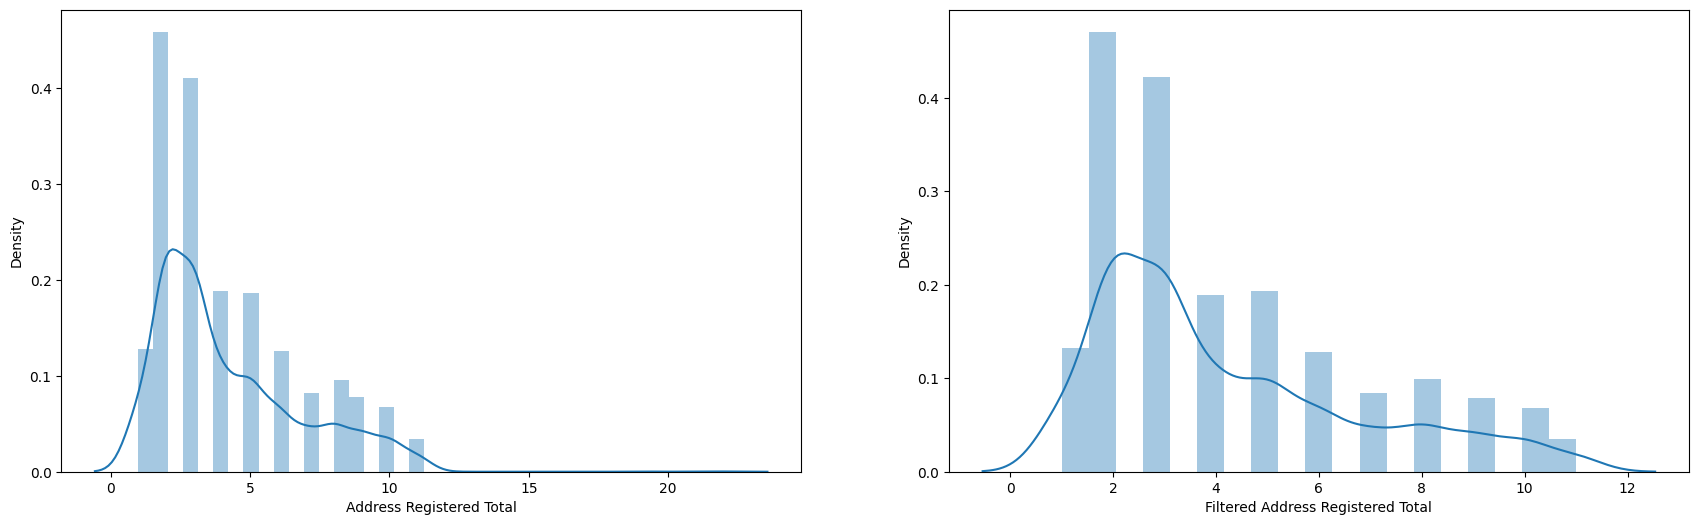

In [25]:
fig, axes = plt.subplots(1,2, figsize=(21, 6))
sns.distplot(df3['NumberOfAddress'], ax=axes[0])
sns.distplot(df4['NumberOfAddress'], ax=axes[1])
axes[0].set_xlabel('Address Registered Total')
axes[1].set_xlabel('Filtered Address Registered Total')

Text(0.5, 0, 'Filtered Since Last Order')

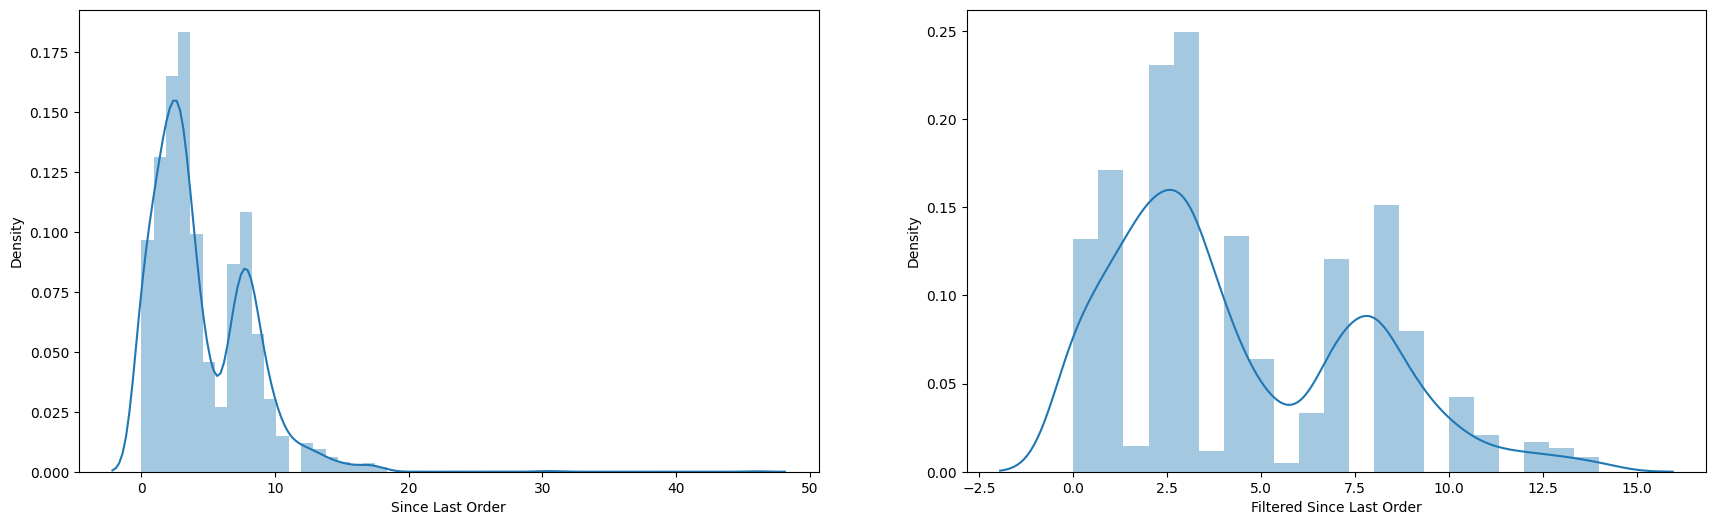

In [26]:
fig, axes = plt.subplots(1,2, figsize=(21, 6))
sns.distplot(df3['DaySinceLastOrder'], ax=axes[0])
sns.distplot(df4['DaySinceLastOrder'], ax=axes[1])
axes[0].set_xlabel('Since Last Order')
axes[1].set_xlabel('Filtered Since Last Order')

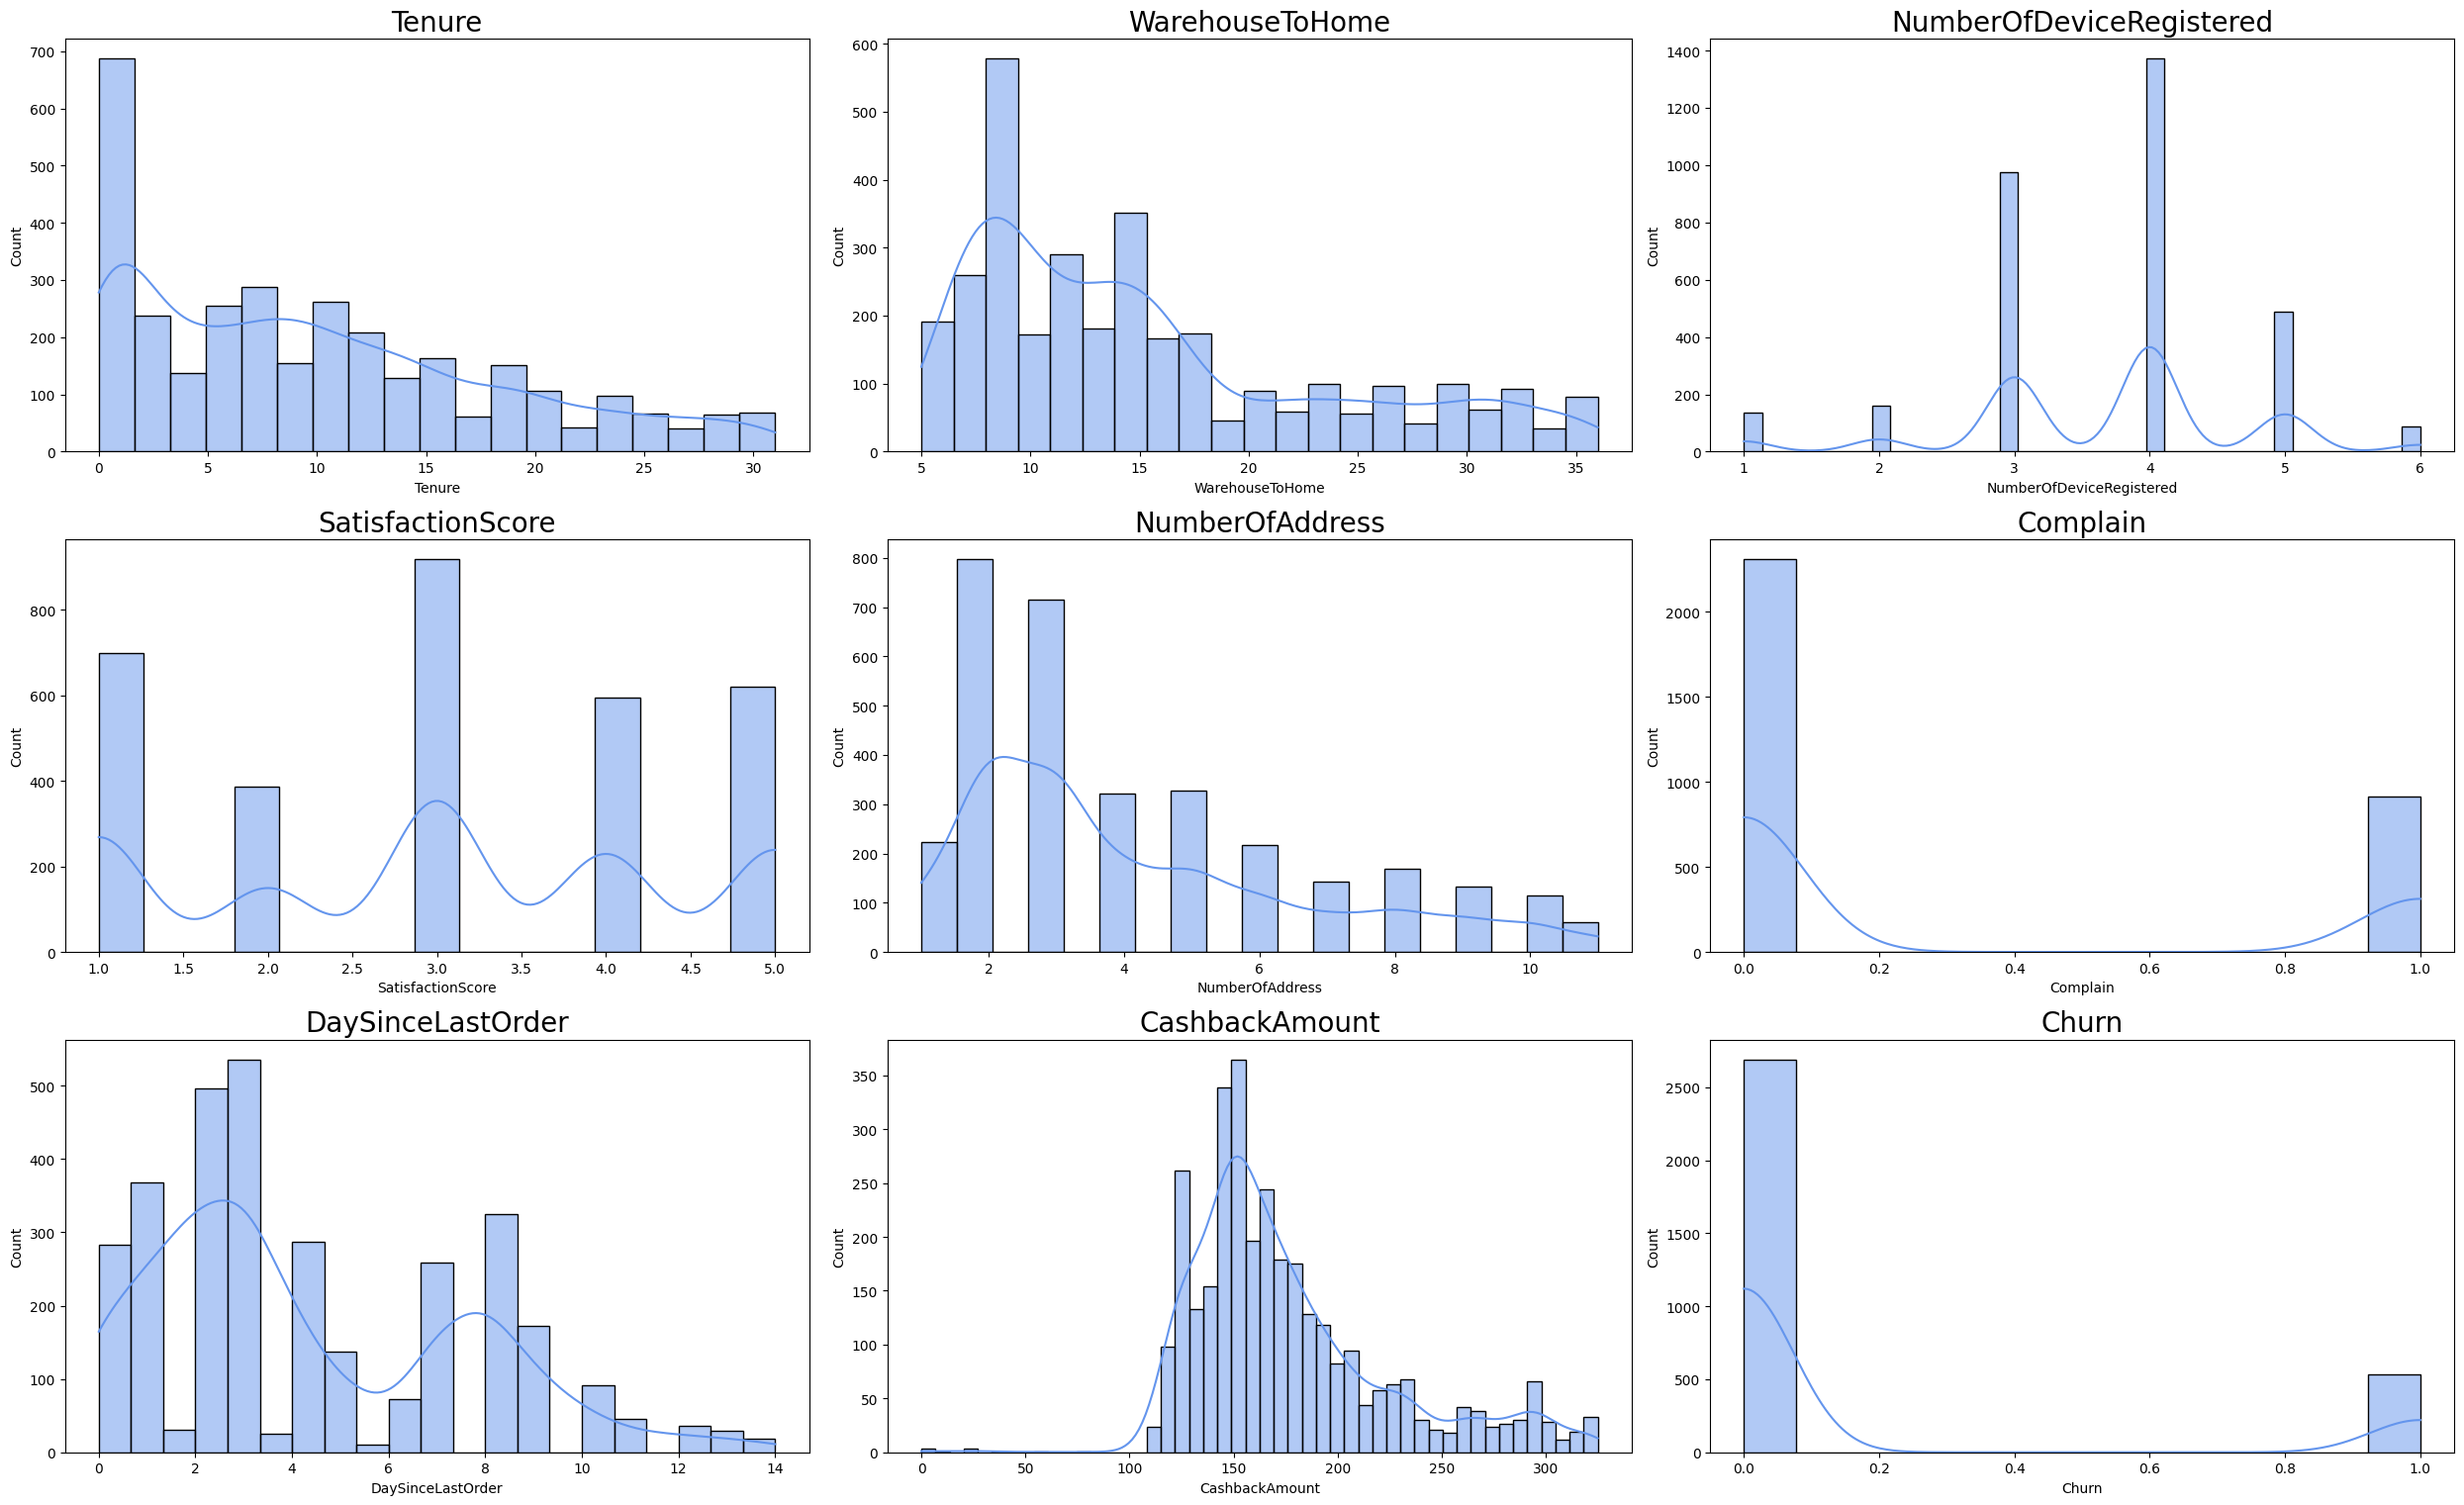

In [27]:
# Melihat sebaran data kolom numerik
plt.figure(figsize=(25, 25))
plotnumber = 1
num_features = df4.select_dtypes(include='number').columns

for feature in num_features:
    ax = plt.subplot(5, 3, plotnumber)
    sns.histplot(data=df4,x=feature,color='cornflowerblue', kde=True)
    plt.title(feature, fontsize=20)
    plotnumber += 1
    plt.tight_layout()

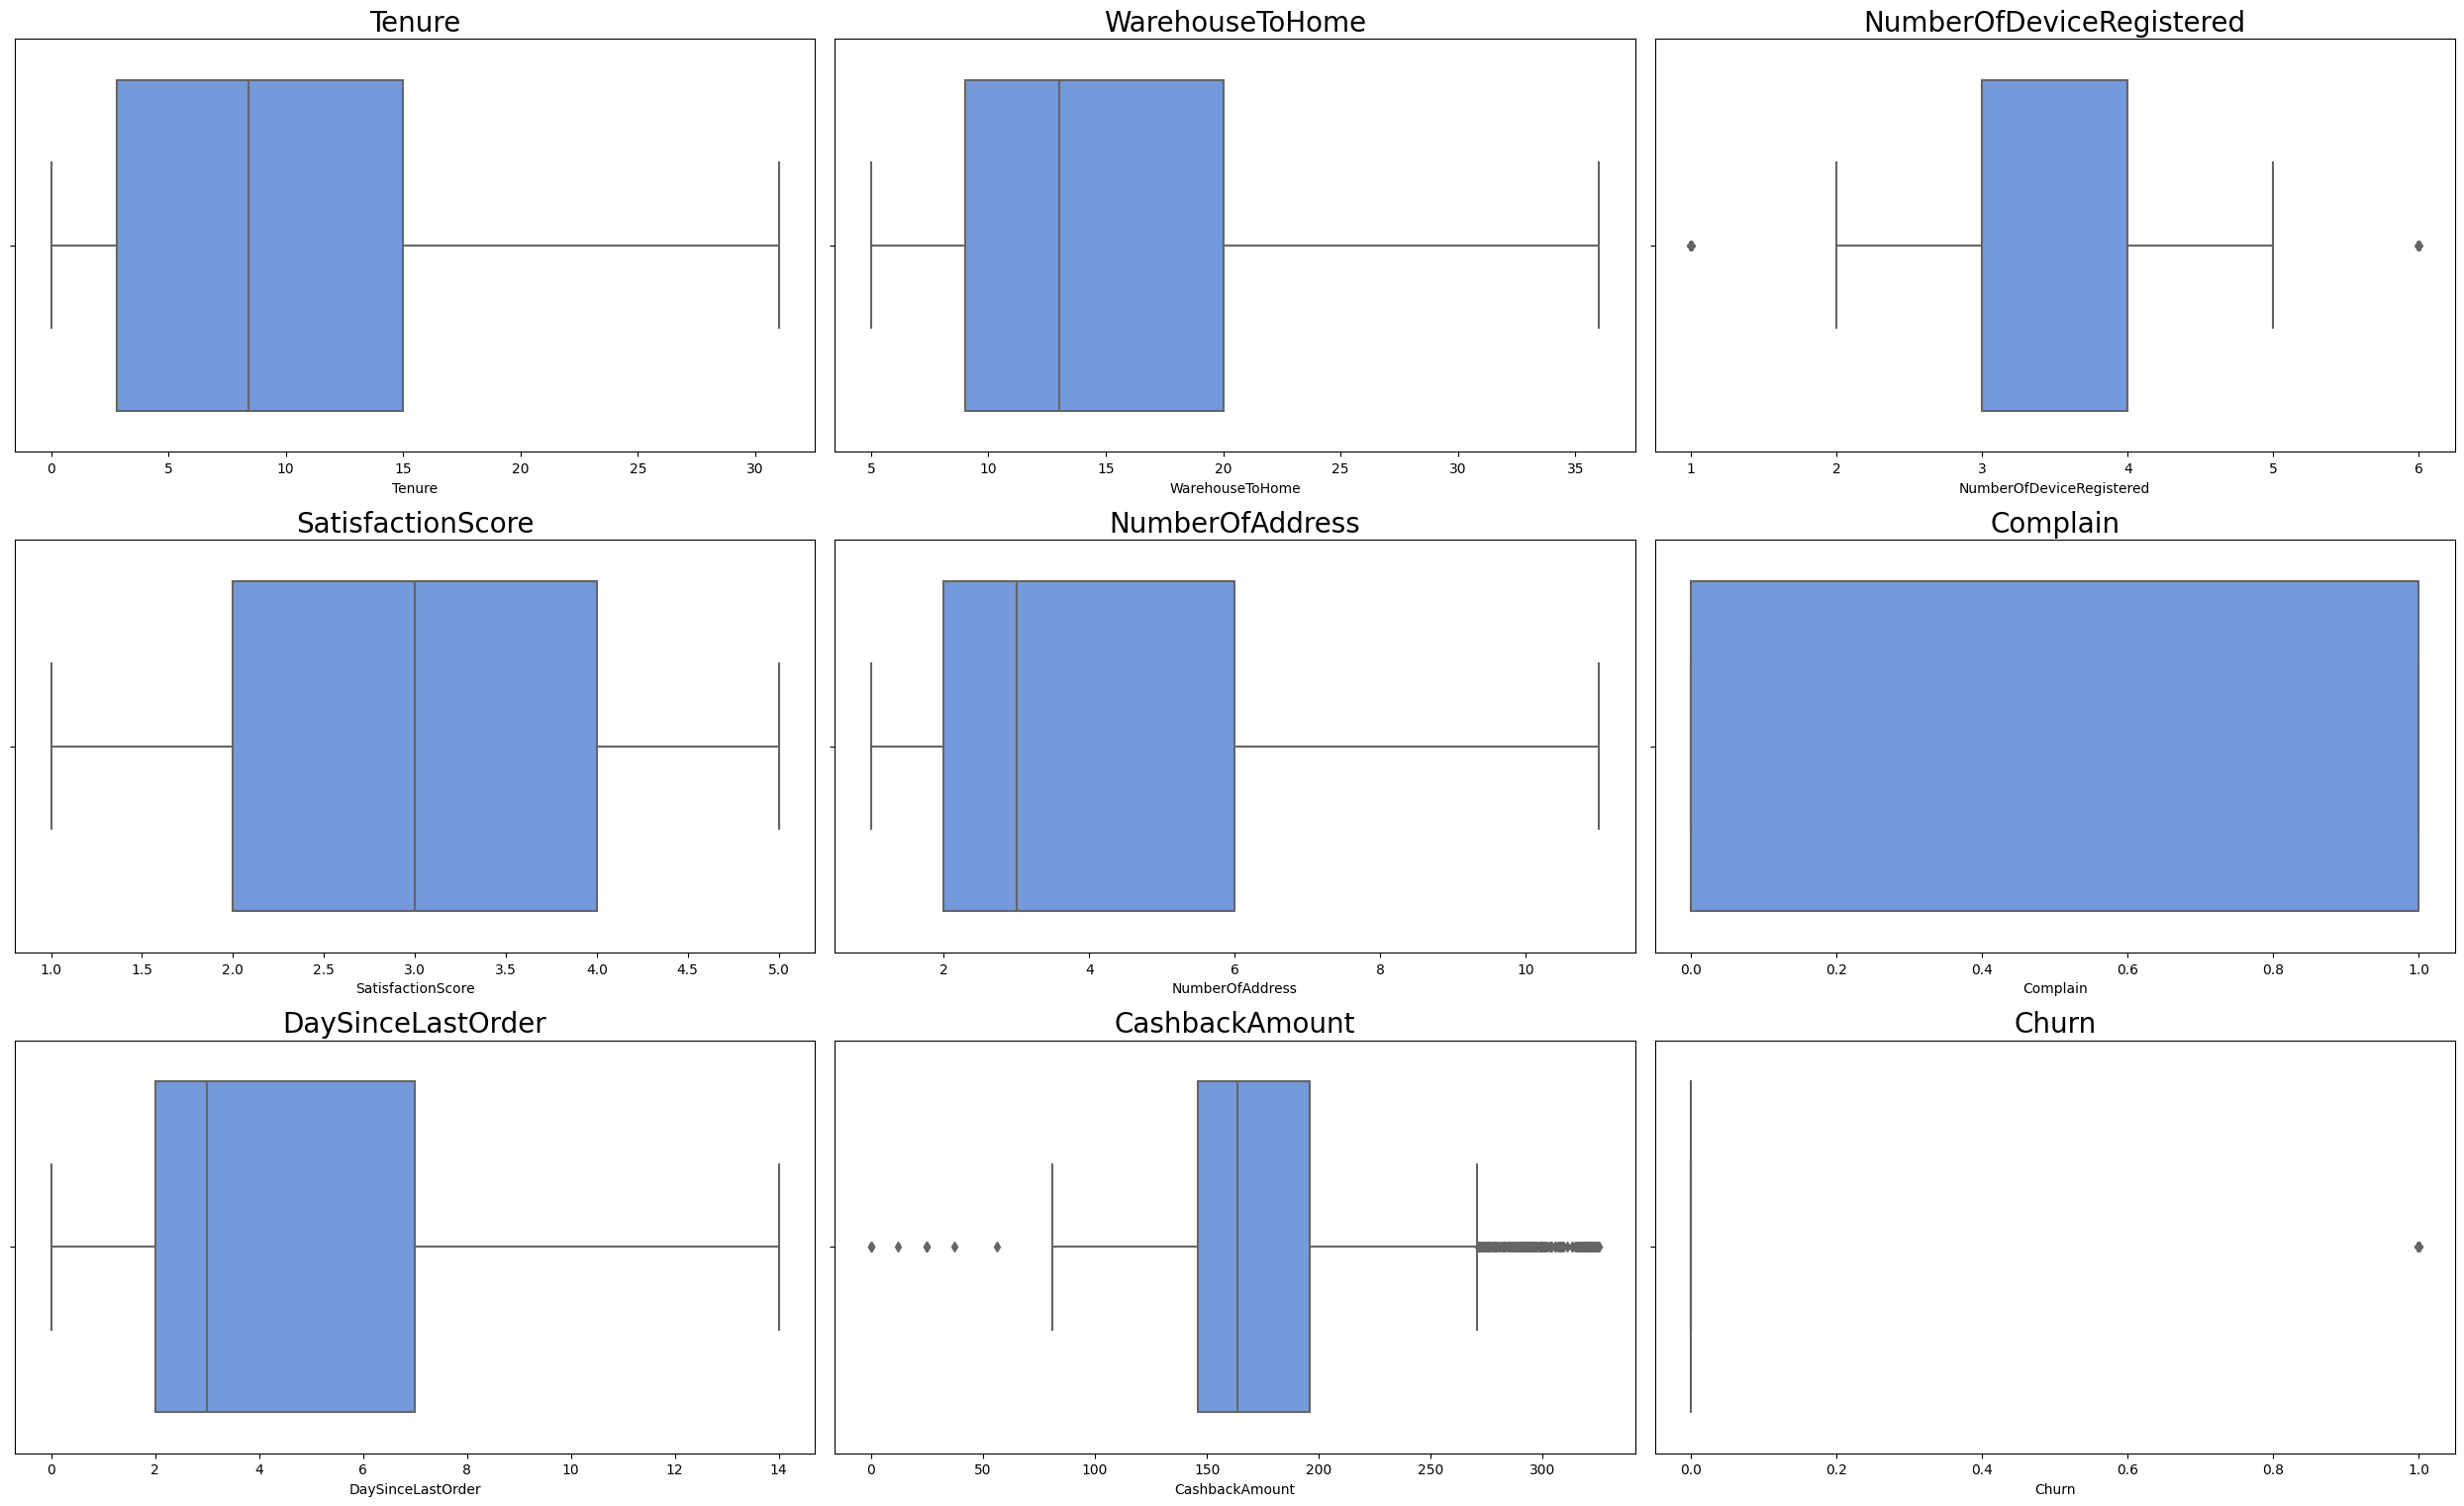

In [28]:
plt.figure(figsize=(25, 25))
plotnumber = 1
num_features = df4.select_dtypes(include='number').columns

for feature in num_features:
    ax = plt.subplot(5, 3, plotnumber)
    sns.boxplot(data=df4,x=feature,color='cornflowerblue')
    plt.title(feature, fontsize=20)
    plotnumber += 1
    plt.tight_layout()

In [29]:
print(f'Jumlah baris df (data asli):',df.shape[0], 'baris')
print(f'Jumlah baris df2 (data yang sudah terhandle duplicate):',df2.shape[0],'baris')
print(f'Jumlah baris df3 (df2 yang sudah dihandle missing valuenya):',df3.shape[0],'baris')
print(f'Jumlah baris df4 (df3 yang sudah dihandle outliersnya):',df4.shape[0],'baris')

Jumlah baris df (data asli): 3941 baris
Jumlah baris df2 (data yang sudah terhandle duplicate): 3269 baris
Jumlah baris df3 (df2 yang sudah dihandle missing valuenya): 3269 baris
Jumlah baris df4 (df3 yang sudah dihandle outliersnya): 3221 baris


Disini saya membuat dataframe baru dengan nama **df3** agar ketika modelling kita bisa membandingkan dengan **df2** yang outliersnya belum di handle. Hingga tahap ini dapat disimpulkan bahwa:

* **df** = Dataframe asli, memiliki 3941 baris
* **df2** = Dataframe yang sudah terhandle duplicatenya, memiliki 3269 baris
* **df3** = **df2** yang sudah terhandle missing value-nya memiliki 3269 baris
* **df4** = **df3** yang sudah terhandle outliers-nya memiliki 3221 baris

Dalam modelling, nantinya kita akan mengecek mana yang sekiranya lebih baik antara df3 (outliers belum dihandle) atau df4 (outlier sudah dihandle).

# Exploratory Data Analysis (EDA)

Setelah kita melakukan pembersihan terhadap data, sekarang saatnya kita melakukan analisa lebih dalam terhadap data agar mendapat gambaran apa yang sebenernya terjadi berdasarkan data yang kita punya. Dalam hal ini saya menggunakan **df2** agar kita menganalisa tanpa terganggu data yang terduplikasi.

## Cek Multikolinearitas

Text(0.5, 1.0, 'Correlation Matrix')

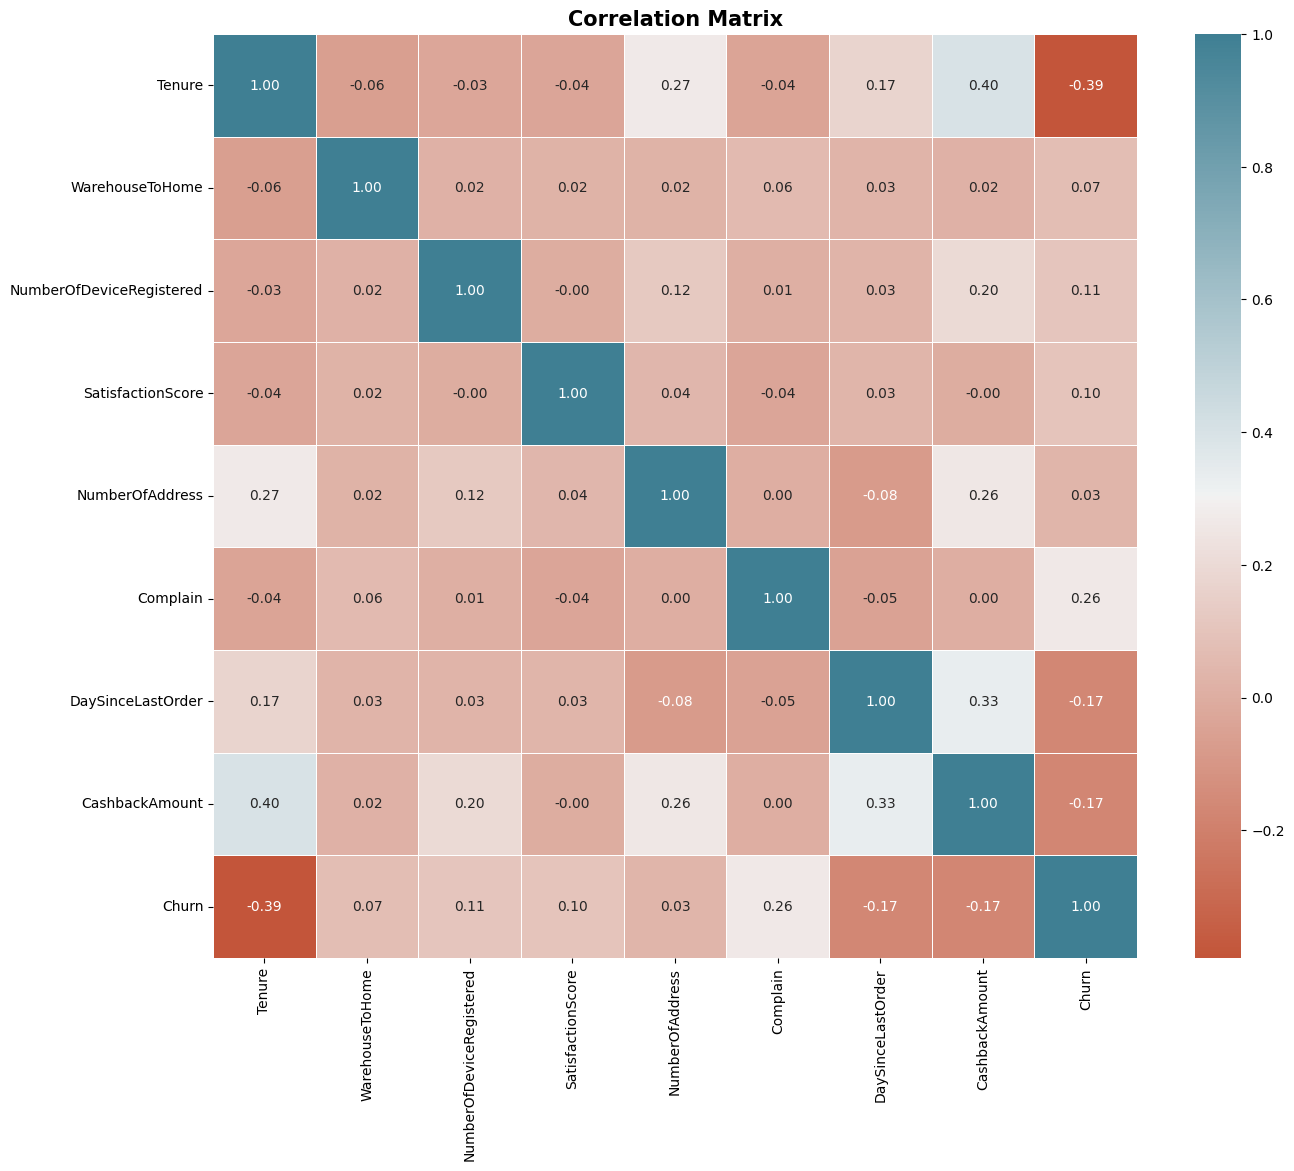

In [30]:
## Cek Multikolinearitas
num_col = df3[['Tenure',
              'WarehouseToHome',
              'NumberOfDeviceRegistered',
              'SatisfactionScore',
              'NumberOfAddress',
              'Complain','DaySinceLastOrder',
              'CashbackAmount',
              'Churn']]
plt.figure(figsize = (15, 12))
palette = sns.diverging_palette(20, 220, n = 256)
corr = num_col.corr(method='spearman')
sns.heatmap(corr, annot = True, fmt = '.2f', cmap = palette, square = True, linewidths = .5)
plt.title('Correlation Matrix', size = 15, weight = 'bold')

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(num_col):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = num_col.columns
    vif["VIF"] = [variance_inflation_factor(num_col.values, i) for i in range(num_col.shape[1])]

    return(vif)

calc_vif(num_col)

,variables,VIF
0,Tenure,3.536789
1,WarehouseToHome,4.001538
2,NumberOfDeviceRegistered,10.371648
3,SatisfactionScore,5.009768
4,NumberOfAddress,3.911834
5,Complain,1.500620
6,DaySinceLastOrder,2.877152
7,CashbackAmount,15.818844
8,Churn,1.531763


Dapat kita lihat berdasarkan skor VIF bahwa kolom `CashbackAmount` dan `NumberOfDeviceRegistered` memiliki nilai VIF tinggi, hal itu bertanda bahwa kolom tersebut berkorelasi dengan variabel lain. Dapat kita lihat dari Correlation Matrix bahwa kolom terebut berkorelasi dengan kolom-kolom lainnya. Hal ini menandakan butuh penanganan lebih lanjut.

## Churn vs No Churn

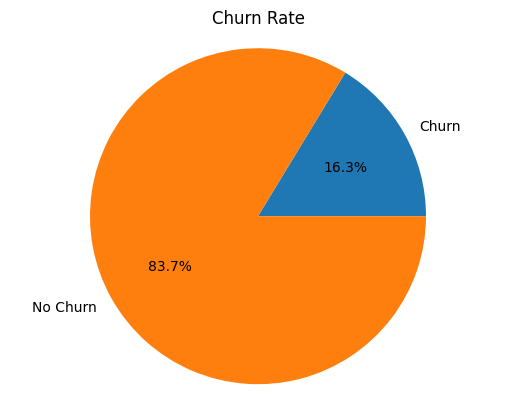

In [32]:
labels = ['Churn', 'No Churn']
sizes = [
    len(df2[(df2['Churn'] == 1)]),
    len(df2[(df2['Churn'] == 0)])
]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Churn Rate')
plt.show()

16.3% pelanggan churn dan 83.7% pelanggan tidak churn, dengan kata lain perusahaan kehilangan revenue sebanyak 16.3% dari pelangganData churn. Dari grafik terlihat data memiliki imbalance sehingga dapat dilakukan treatment untuk menjadi salah satu alternatif solusi untuk meningkatkan nilai recall.

## Tenure

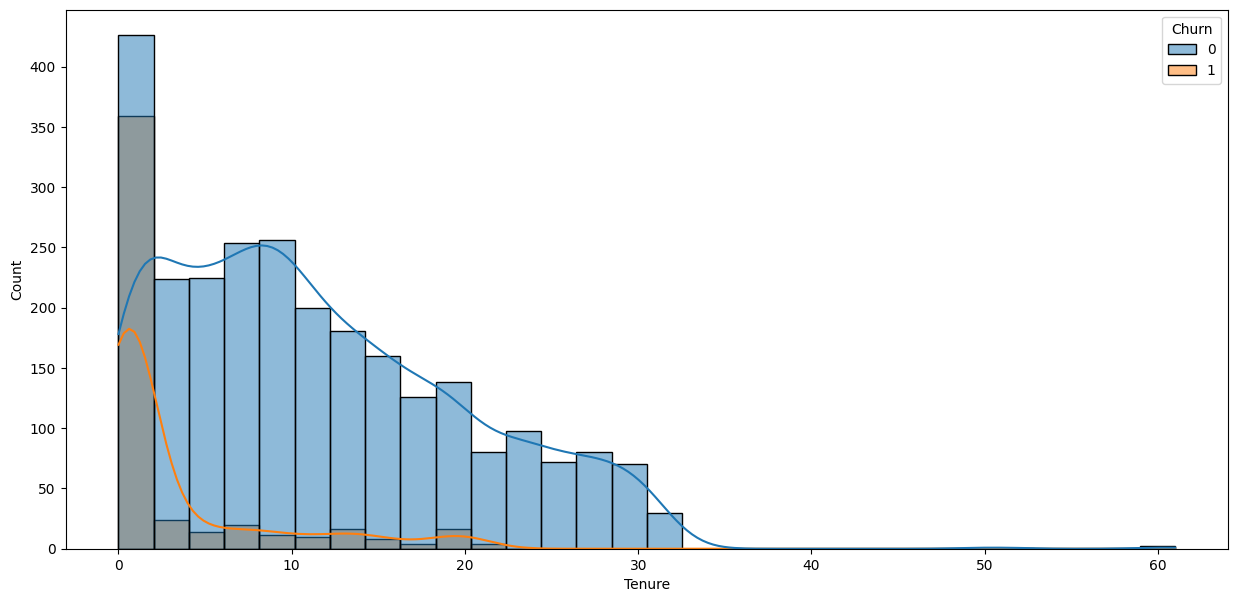

In [33]:
tenure = df2[['Tenure']]
plt.figure(figsize=(15,7))
for i in tenure:
    sns.histplot(data=df2,x=i,hue='Churn',kde=True,bins=30)
    plt.show()


Dari boxplot tersebut pula, dapat kita simpulkan bahwa pelanggan churn paling banyak adalah yang memiliki Tenure rendah, hal ini bisa disebabkan oleh pelanggan hanya tertarik untuk mengetahui bagaimana E-Commerce tersebut bekerja dan membandingkan dengan e-commerce yang biasa digunakan oleh pelanggan tersebut.

## Cashback Amount

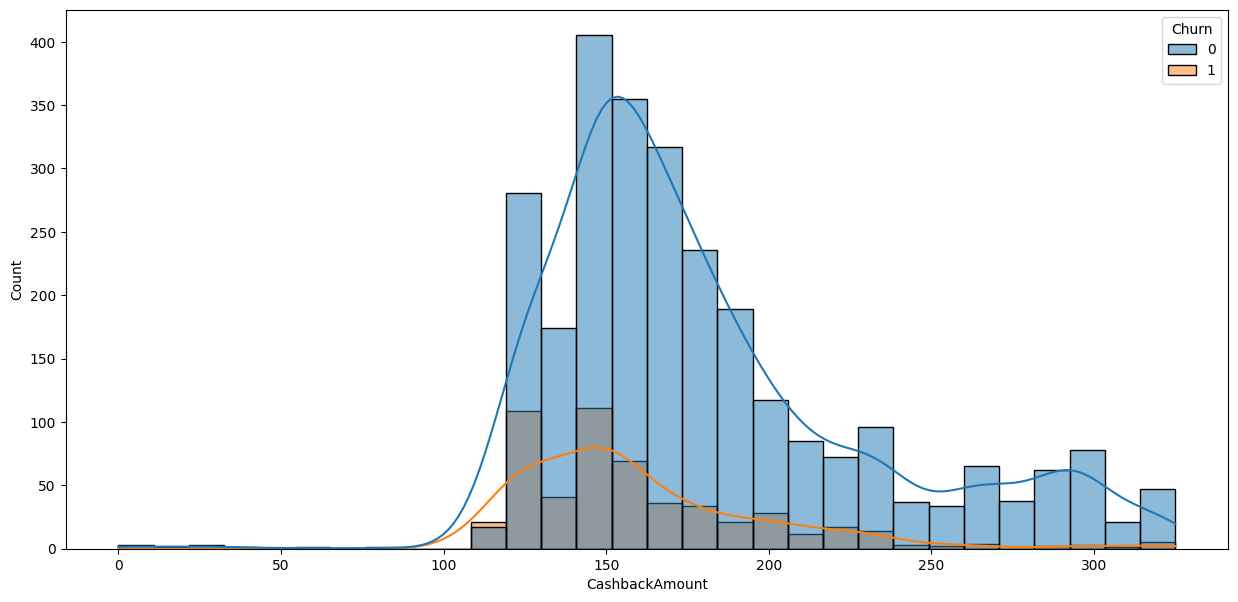

In [34]:
cashback = df2[['CashbackAmount']]
plt.figure(figsize=(15,7))
for i in cashback:
    sns.histplot(data=df2,x=i,hue='Churn',kde=True,bins=30)
    plt.show()

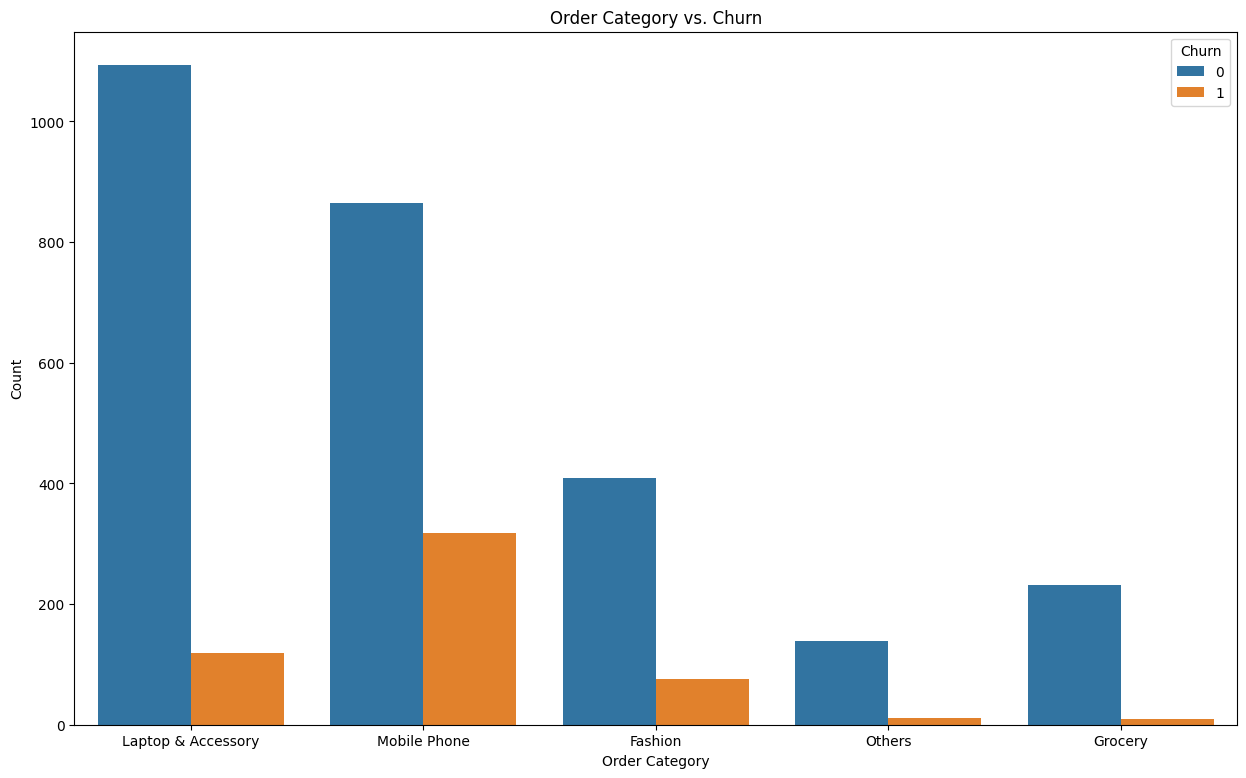

In [35]:
plt.figure(figsize=(15, 9))
sns.countplot(data=df2, x='PreferedOrderCat', hue='Churn')
plt.xlabel('Order Category')
plt.ylabel('Count')
plt.title('Order Category vs. Churn')
plt.show()

Berdasarkan grafik di atas, dapat kita lihat bahwa customer yang paling banyak churn adalah pelanggan yang mencari Mobile Phone. Hal ini bisa terjadi karena kurangnya promosi atau kurang variatifnya jenis Mobile Phone ini. Untuk kategori grocery paling sedikit Churn-nya karena grocery merupakan kebutuhan rumah tangga yang pasti sering dicari oleh masyarakat pada umumnya.

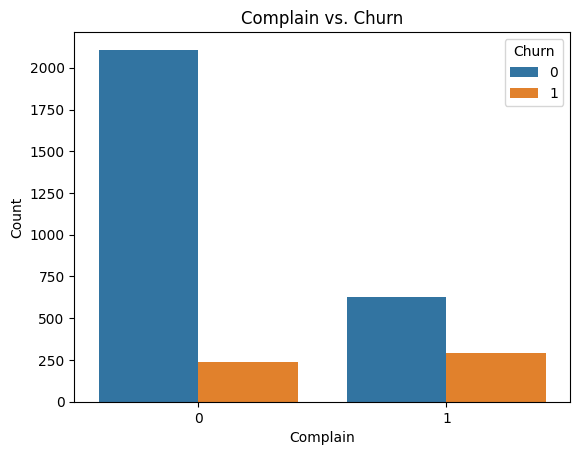

In [36]:
sns.countplot(data=df2, x='Complain', hue='Churn')
plt.xlabel('Complain')
plt.ylabel('Count')
plt.title('Complain vs. Churn')
plt.show()

Berdasarkan grafik, pelanggan yang melakukan komplain paling banyak melakukan churn, hal ini bisa disebabkan oleh komplain yang kurang ditangani dengan baik.

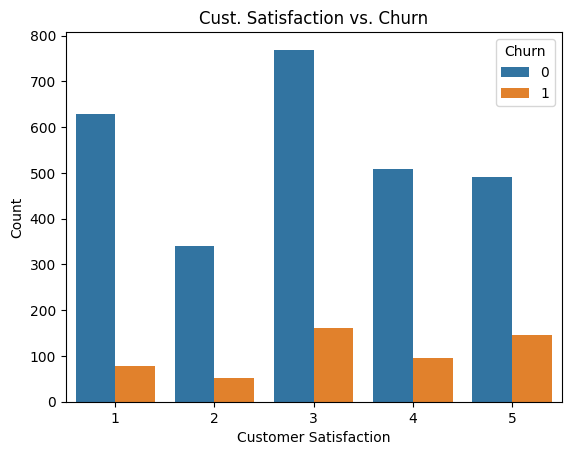

In [37]:
sns.countplot(data=df2, x='SatisfactionScore', hue='Churn')
plt.xlabel('Customer Satisfaction')
plt.ylabel('Count')
plt.title('Cust. Satisfaction vs. Churn')
plt.show()

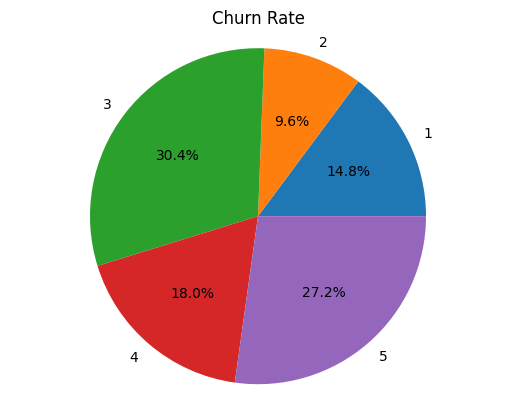

In [38]:
labels = ['1','2','3','4','5']
sizes = [
    len(df2[(df2['SatisfactionScore'] == 1) & (df2['Churn']==1)]),
    len(df2[(df2['SatisfactionScore'] == 2) & (df2['Churn']==1)]),
    len(df2[(df2['SatisfactionScore'] == 3) & (df2['Churn']==1)]),
    len(df2[(df2['SatisfactionScore'] == 4) & (df2['Churn']==1)]),
    len(df2[(df2['SatisfactionScore'] == 5) & (df2['Churn']==1)])
]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Churn Rate')
plt.show()

Dapat kita lihat bahwa di sini terdapat anomali, bahwa pelanggan tingkat kepuasannya tinggi menempati urutan kedua dalam melakukan churn. Hal ini dapat menunjukkan bahwa ada kemungkinan adanya ...

# Data Preprocessing

Sebelum kita melakukan data splitting. Ada baiknya kita melakukan preprocessing kepada data. Sudah kita ketahui sebelumnya, bahwa data kita memliki missing values yang harus kita handling. Selain itu, perlu kita ingat kita juga memiliki Outliers yang perlu ditelaah apakah perlu dihapus atau tidak. Oleh karena itu, berikut strategi saya dalam melakukan data preprocessing melalui proses ColumnTransformer.

* Encoder One Hot -> Untuk merubah variabel kategorik menjadi numerik pada kolom `MaritalStatus`
* Binary Encoder -> Untuk merubah variabel kategorik menjadi numerik pada kolom `PreferedOrderCat`
* KBinsDescritizer -> Untuk merubah variabel numerik `CashbackAmount` menjadi urutan kelas ordinal dengan width yang sama.

Encoder baik itu One Hot dan Binary bekerja dengan prinsip suatu fitur kategorik akan dikonversi dengan menambahkan kolom dengan jumlah yang sesuai dengan variasi nilai data, selanjutnya akan diisikan nilai dengan angka 0 dan 1 sesuai dengan nilai pada datanya. 

Perbedaan One Hot dan Binary paling utama ada pada jumlah kolom yang ditambahkan, semakin banyak variabel kategorik, jumlah kolom yang ditambahkan semakin banyak. Sedangkan pada Binary Encoder, setiap kolom akan memiliki nilai biner 0 atau 1, yang mewakili bit ke-n dari bilangan biner yang digunakan untuk mengkode kategori. Sehingga kolom yang ditambahkan tidak terlalu banyak.

* Scaling, Robust Scaler -> Untuk melakukan scaling terhadap kolom numerik diskrit, karena data memiliki outliers dan jenis scaling ini lebih tahan kepada outlier. Data yang sudah discaled hanya digunakan pada modeling untuk Logistic Regression

Selain itu saya akan menyiapkan transformer tanpa scaler untuk diaplikasikan kepada model tree based.

In [39]:
kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
# Transform Kolom tanpa scaler untuk model tree based
transformer = ColumnTransformer([('one hot encoder',OneHotEncoder(drop = 'first'),['MaritalStatus']),
                                 ('binary encoder', ce.BinaryEncoder(), ['PreferedOrderCat']),
                                 ('binner', kbd, ['CashbackAmount'])
                                 ], remainder = 'passthrough')

# Transform kolom dengan scaling utk kolom numerik
scaler = RobustScaler()
trans_scaled = ColumnTransformer([('one hot encoder',OneHotEncoder(drop = 'first'),['MaritalStatus']),
                                  ('binary encoder', ce.BinaryEncoder(), ['PreferedOrderCat']),
                                  ('binner', kbd, ['CashbackAmount']),
                                 ('scaler',scaler,['Tenure','WarehouseToHome','DaySinceLastOrder'])
                                 ], remainder = 'passthrough')
 

# Data Splitting

Pada proses ini kita akan membagi data pada variabel X (Fitur) dan y (Target). Perlu kita ingat juga, bahwa kita memiliki 2 data frame, yaitu **df3** yang memiliki outliers dan **df4** yang outliersnya telah dihandle, nanti kita akan membandingkan data mana yang terbaik untuk modelling.

In [40]:
# Data df3 (Memiliki outliers)
X_out = df3.drop(['Churn'], axis=1)
y_out = df3['Churn']

# Data df4 (Outliers telah dihandle)
X = df4.drop(['Churn'], axis=1)
y = df4['Churn']

print(X_out.shape)
print(y_out.shape)
print(X.shape)
print(y.shape)

(3269, 10)
(3269,)
(3221, 10)
(3221,)


## Train & Test Split

Kita akan menggunakan proporsi (80:20)

In [41]:
X_out_train, X_out_test, y_out_train, y_out_test = train_test_split(
    X_out,
    y_out,
    stratify=y_out,
    test_size=0.2,
    random_state=23
)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.2,
    random_state=23
)

In [42]:
print(X_out_train.shape)
print(y_out_train.shape)
print(X_out_test.shape)
print(y_out_test.shape)

(2615, 10)
(2615,)
(654, 10)
(654,)


# Model & Evaluation

Kali ini kita akan melakukan benchmarking pada beberapa model dengan menggunakan metriks skoring ROC-AUC. Di sini kita akan menggunakan ROC-AUC karena saya ingin melihat bagaimana kemampuan model dalam mendetermminasi kelas 0 (negatif churn) dan 1 (positif churn). Hal ini dilakukan dengan membandingkan nilai TPR (True Positive Rate) atau yang biasa disebut Recall dan FPR.

Kita akan membandingkan 5 algoritma modelling, yaitu:

1. Decision Tree
2. Random Forest
3. Logistic Regression
4. XGBoost 
5. LightGBM

In [43]:
dt = Pipeline([('transformer',transformer),('model',DecisionTreeClassifier(random_state=1004))])
rf = Pipeline([('transformer',transformer),('model',RandomForestClassifier(random_state=1004))])
lr = Pipeline([('transformer',trans_scaled),('model',LogisticRegression(random_state=1004))])
xgb = Pipeline([('transformer',transformer),('model',XGBClassifier(random_state=1004))])
lgbm = Pipeline([('transformer',transformer),('model',LGBMClassifier(random_state=1004, verbosity=0))])


## Benchmarking Data Dengan Outliers

In [44]:
# Benchmarking Data Dengan Outliers
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state = 1)
models = [dt, rf, lr, xgb, lgbm]
score_cv_out = []
std_cv_out = []
score_out = []
nama = ['Decision Tree','Random Forest','Logistic Regression','XGBoost','LGBM']

# Training Model
for model in models:
    cv_recall_out = cross_val_score(
        model,
        X_out_train,
        y_out_train,
        cv = kfold,
        scoring = 'roc_auc'
    )
    score_cv_out.append(cv_recall_out.mean())
    std_cv_out.append(cv_recall_out.std())

# Test Model
for model in models:
    model.fit(X_out_train, y_out_train)
    prediction_out = model.predict(X_out_test)
    rocauc_out = roc_auc_score(y_out_test, prediction_out)
    score_out.append(rocauc_out)

show_out = pd.DataFrame({
    'Nama': nama,
    'Train Mean Outlier': score_cv_out,
    'Standar Deviasi Outlier': std_cv_out,
    'Test Score Outlier': score_out
}).sort_values(by='Train Mean Outlier', ascending=False)
show_out


,Nama,Train Mean Outlier,Standar Deviasi Outlier,Test Score Outlier
4,LGBM,0.941590,0.015181,0.855448
3,XGBoost,0.936515,0.018412,0.864794
1,Random Forest,0.934220,0.020308,0.805062
2,Logistic Regression,0.879349,0.022861,0.751021
0,Decision Tree,0.808359,0.053092,0.834321


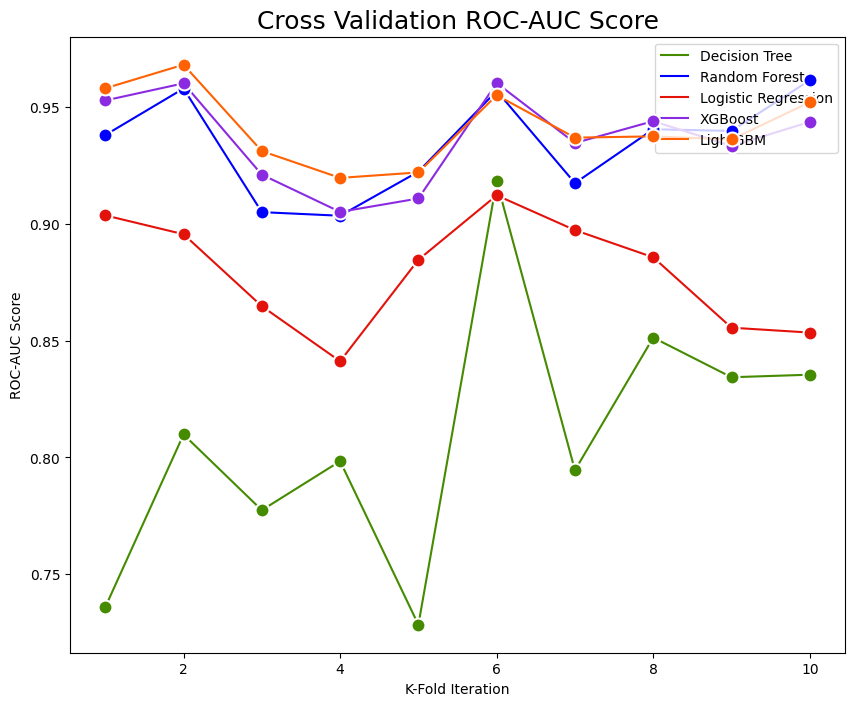

In [45]:
# Grafik hasil training pada data dengan outliers
PURPLE = "#8A2BE2"
GREEN = "#458B00"
BLUE = "#0000FF"
ORANGE = "#FF6103"
RED = "#E3120B"

COLORS = [GREEN, BLUE, RED, PURPLE, ORANGE]
models = [dt, rf, lr, xgb, lgbm]
score_recall = []
nama = ['Decision Tree', 'Random Forest', 'Logistic Regression', 'XGBoost', 'LightGBM']

for model, model_name in zip(models, nama):
    cv_recall = cross_val_score(
        model,
        X_out_train,
        y_out_train,
        cv=kfold,
        scoring='roc_auc'
    )
    score_recall.append(cv_recall)

fig, ax = plt.subplots(figsize=(10, 8))
for i, color, label in zip(range(len(models)), COLORS, nama):
    ax.plot(range(1,11,1), score_recall[i], color=color, label=label, lw=1.5)
    ax.legend(loc='upper right')
    ax.scatter(range(1,11,1), score_recall[i], fc=color, s=100, lw=1.5, ec="white", zorder=12)

plt.title('Cross Validation ROC-AUC Score', fontsize=18, loc='center')
ax.set_xlabel('K-Fold Iteration')
ax.set_ylabel('ROC-AUC Score')
plt.show()

Berdasarkan hasil benchmarking, dapat kita lihat bahwa pada algoritma XGBoost dan Decision Tree membawa hasil yang baik pada data yang memiliki outliers. Selanjutnya kita akan melihat bagaimana data yang sudah dihandle outliersnya.

## Benchmarking Pada Data Tanpa Outliers

In [46]:
# Benchmarking Data Tanpa Outliers
score_cv = []
std_cv = []
score = []
nama = ['Decision Tree','Random Forest','Logistic Regression','XGBoost','LGBM']

# Training Model
for model in models:
    cv_recall = cross_val_score(
        model,
        X_train,
        y_train,
        cv = kfold,
        scoring = 'roc_auc'
    )
    score_cv.append(cv_recall.mean())
    std_cv.append(cv_recall.std())

# Test Model
for model in models:
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    rocauc = roc_auc_score(y_test, prediction)
    score.append(rocauc)

show = pd.DataFrame({
    'Nama': nama,
    'Train Mean': score_cv,
    'Standar Deviasi': std_cv,
    'Test Score': score
}).sort_values(by='Train Mean', ascending=False)
show

,Nama,Train Mean,Standar Deviasi,Test Score
4,LGBM,0.938909,0.023053,0.808774
3,XGBoost,0.936946,0.025456,0.828570
1,Random Forest,0.936444,0.025720,0.791761
2,Logistic Regression,0.882851,0.028536,0.712658
0,Decision Tree,0.805630,0.047472,0.785347


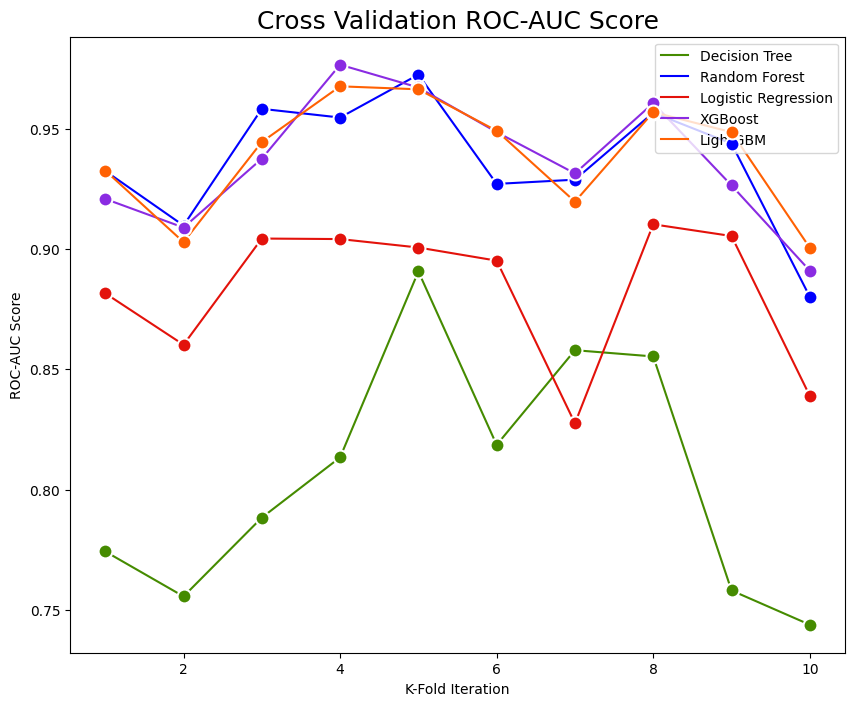

In [47]:
# Grafik hasil training pada data tanpa outliers
PURPLE = "#8A2BE2"
GREEN = "#458B00"
BLUE = "#0000FF"
ORANGE = "#FF6103"
RED = "#E3120B"

COLORS = [GREEN, BLUE, RED, PURPLE, ORANGE]
models = [dt, rf, lr, xgb, lgbm]
score_recall = []
nama = ['Decision Tree', 'Random Forest', 'Logistic Regression', 'XGBoost', 'LightGBM']

for model, model_name in zip(models, nama):
    cv_recall = cross_val_score(
        model,
        X_train,
        y_train,
        cv=kfold,
        scoring='roc_auc'
    )
    score_recall.append(cv_recall)

fig, ax = plt.subplots(figsize=(10, 8))
for i, color, label in zip(range(len(models)), COLORS, nama):
    ax.plot(range(1,11,1), score_recall[i], color=color, label=label, lw=1.5)
    ax.legend(loc='upper right')
    ax.scatter(range(1,11,1), score_recall[i], fc=color, s=100, lw=1.5, ec="white", zorder=12)

plt.title('Cross Validation ROC-AUC Score', fontsize=18, loc='center')
ax.set_xlabel('K-Fold Iteration')
ax.set_ylabel('ROC-AUC Score')
plt.show()

In [48]:
show_out.head(2)

,Nama,Train Mean Outlier,Standar Deviasi Outlier,Test Score Outlier
4,LGBM,0.941590,0.015181,0.855448
3,XGBoost,0.936515,0.018412,0.864794


In [49]:
show.head(2)

,Nama,Train Mean,Standar Deviasi,Test Score
4,LGBM,0.938909,0.023053,0.808774
3,XGBoost,0.936946,0.025456,0.828570


Berdasarkan hasil benchmarking di atas, dapat kita lihat bahwa pada data yang tidak memiliki outliers, algoritma LightGBM dan XGBoost menempati posisi kedua teratas. Namun berdasarkan test score, algoritma LightGBM pada data yang memiliki outliers lebih baik dalam testing.

Untuk selanjutnya kita akan memilih algoritma LightGBM untuk modelling terhadap data yang memiliki outliers untuk selanjutnya kita tuning dan handling imbalance pada kolom **`Churn`**.

## Handling Imbalance

Setelah menentukan model mana yang akan kita teruskan, kita akan melakukan tuning pada datanya. Tapi sebelum dilakukan tuning, berdasarkan EDA dapat kita ketahui bahwa terdapat perbedaaan kelas yang akan berdampak pada ke-akuratan model machine learning. Di sini kita akan melakukan handling imbalance terhadap variabel target.

Kita akan melakukan perbandingan antara metode _Random Oversampling_, _SMOTE_, dan _Random Undersampling_.

In [50]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=1)
rus = RandomUnderSampler(sampling_strategy='auto', random_state=1)
smote = SMOTE(random_state=1)

### Handling Imbalance Random Oversampler - LightGBM (Data dengan Outliers)

In [51]:
lgbm_ros = []
test_scores_ros = []

# Train LightGBM w/ Random Oversampler
model_pipe_ros = Pipeline([
        ('transformer',transformer),
        ('balancing', ros),
        ('model', LGBMClassifier(random_state=1004,verbosity=0))
        ])
lgbm_ros_cv = cross_val_score(model_pipe_ros, 
                              X_out_train,
                              y_out_train,
                              cv = kfold,
                              scoring = 'roc_auc')
lgbm_ros.append(lgbm_ros_cv)
ros_values = lgbm_ros[0]

# Test LightGBM w/ Random Oversampler

for train_index, test_index in kfold.split(X_out_train, y_out_train):
    X_out_train_fold, X_out_test_fold = X_out_train.iloc[train_index], X_out_train.iloc[test_index]
    y_out_train_fold, y_out_test_fold = y_out_train.iloc[train_index], y_out_train.iloc[test_index]

    model_pipe_ros.fit(X_out_train_fold, y_out_train_fold)
    y_pred_lgbm = model_pipe_ros.predict(X_out_test_fold)
    rocauc_ros = roc_auc_score(y_out_test_fold, y_pred_lgbm)
    test_scores_ros.append(rocauc_ros)


result_ros = pd.DataFrame({
    'Train Test': ros_values,
    'Test Score': test_scores_ros})
result_ros.loc['Average'] = result_ros.mean()
result_ros

,Train Test,Test Score
0,0.944462,0.891207
1,0.975576,0.863173
2,0.931507,0.840342
3,0.915472,0.830785
4,0.920357,0.830997
5,0.947271,0.873777
6,0.941944,0.868232
7,0.945423,0.832518
8,0.944988,0.872798
9,0.958609,0.858492


#### Handling Imbalance - Random Undersampler

In [52]:
lgbm_rus = []
test_scores_rus = []

# Train LightGBM w/ Random Undersampler
model_pipe_rus = Pipeline([
        ('transformer',transformer),
        ('balancing', rus),
        ('model', LGBMClassifier(random_state=1004,verbosity=0))
        ])
lgbm_rus_cv = cross_val_score(model_pipe_rus, 
                              X_out_train,
                              y_out_train,
                              cv = kfold,
                              scoring = 'roc_auc')
lgbm_rus.append(lgbm_rus_cv)
rus_values = lgbm_rus[0]

# Test LightGBM w/ Random Undersampler
for train_index, test_index in kfold.split(X_out_train, y_out_train):
    X_out_train_fold, X_out_test_fold = X_out_train.iloc[train_index], X_out_train.iloc[test_index]
    y_out_train_fold, y_out_test_fold = y_out_train.iloc[train_index], y_out_train.iloc[test_index]

    model_pipe_rus.fit(X_out_train_fold, y_out_train_fold)
    y_pred_lgbm = model_pipe_rus.predict(X_out_test_fold)
    rocauc_rus = roc_auc_score(y_out_test_fold, y_pred_lgbm)
    test_scores_rus.append(rocauc_rus)


result_rus = pd.DataFrame({
    'Train Test': rus_values,
    'Test Score': test_scores_rus})
result_rus.loc['Average'] = result_rus.mean()
result_rus

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,Train Test,Test Score
0,0.941807,0.898694
1,0.941383,0.880217
2,0.902517,0.841191
3,0.900074,0.856961
4,0.916322,0.834342
5,0.932268,0.854207
6,0.911503,0.846869
7,0.919113,0.836269
8,0.914655,0.843607
9,0.907937,0.845050


#### Handling Imbalance - SMOTE

In [53]:
lgbm_smt = []
test_scores_smt = []

# Train LightGBM w/ SMOTE
model_pipe_smt = Pipeline([
        ('transformer',transformer),
        ('balancing', smote),
        ('model', LGBMClassifier(random_state=1004,verbosity=0))
        ])
lgbm_smt_cv = cross_val_score(model_pipe_smt, 
                              X_out_train,
                              y_out_train,
                              cv = kfold,
                              scoring = 'roc_auc')
lgbm_smt.append(lgbm_smt_cv)
smt_values = lgbm_smt[0]

# Test LightGBM w/ SMOTE
for train_index, test_index in kfold.split(X_out_train, y_out_train):
    X_out_train_fold, X_out_test_fold = X_out_train.iloc[train_index], X_out_train.iloc[test_index]
    y_out_train_fold, y_out_test_fold = y_out_train.iloc[train_index], y_out_train.iloc[test_index]

    model_pipe_smt.fit(X_out_train_fold, y_out_train_fold)
    y_pred_lgbm = model_pipe_smt.predict(X_out_test_fold)
    rocauc_smt = roc_auc_score(y_out_test_fold, y_pred_lgbm)
    test_scores_smt.append(rocauc_smt)


result_smt = pd.DataFrame({
    'Train Test': smt_values,
    'Test Score': test_scores_smt})
result_smt.loc['Average'] = result_smt.mean()
result_smt

,Train Test,Test Score
0,0.948285,0.818944
1,0.963895,0.781565
2,0.930339,0.777211
3,0.908145,0.800467
4,0.916109,0.763300
5,0.950968,0.849478
6,0.930746,0.810502
7,0.937052,0.815068
8,0.930637,0.788976
9,0.955302,0.809526


In [54]:
df_ros = result_ros.T
df_rus = result_rus.T
df_smt = result_smt.T

In [55]:
df_ros.rename(columns={'Average':'Random Oversampling'},inplace=True)
df_rus.rename(columns={'Average':'Random Undersampling'},inplace=True)
df_smt.rename(columns={'Average':'SMOTE'},inplace=True)
df_eval = pd.concat([df_ros['Random Oversampling'],df_rus['Random Undersampling'],df_smt['SMOTE']], axis=1)
df_eval

,Random Oversampling,Random Undersampling,SMOTE
Train Test,0.942561,0.918758,0.937148
Test Score,0.856232,0.853741,0.801504


Ternyata dalam menghandle imbalance pada algoritma LightGBM didapatkan hasil terbaik pada metode Random Oversampling. Selanjutnya kita akan melakukan Hyperparameter Tuning menggunakan RandomizedSearchCV

# Hyperparameter Tuning Pada Model Terbaik - LightGBM w/ Random Oversampler

In [56]:
LGBMClassifier().get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [76]:
lgbm_ = LGBMClassifier(random_state=1004,verbosity=0)

# Hyperparam space LightGBM
hyperparam_space_lgbm = {
    'model__num_leaves': st.randint(10, 50),  
    'model__n_estimators': st.randint(100, 1100),  
    'model__learning_rate': st.uniform(0.001, 0.1),  
    'model__max_depth': [-2,-1,1],  
    'model__min_child_samples': st.randint(10, 50),  
    'model__subsample': st.uniform(0.5, 0.5),  
    'model__colsample_bytree': st.uniform(0.5, 0.5),
    'model__reg_alpha': st.uniform(0.0, 0.5),
    'model__reg_lambda': st.uniform(0.0, 0.5)
}
estimator_lgbm = Pipeline([
        ('ROS',ros),
        ('preprocessing',transformer),
        ('model', lgbm_)
        ])

crossval = KFold(n_splits=5, shuffle=True, random_state=1004)

# Hyperparameter tuning
random_lgbm = RandomizedSearchCV(estimator=estimator_lgbm,
                     param_distributions=hyperparam_space_lgbm, 
                     n_iter=100,
                     cv=5, 
                     scoring='roc_auc',
                     n_jobs=-1, 
                     verbose=1, 
                     random_state=1004)

In [58]:
random_lgbm.fit(X_out_train,y_out_train)
print('Nilai terbaik setelah tuning:', random_lgbm.best_score_)
print('Parameter terbaik:', random_lgbm.best_params_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


Nilai terbaik setelah tuning: 0.9321408350472327
Parameter terbaik: {'model__colsample_bytree': 0.665108668769685, 'model__learning_rate': 0.05922047537940195, 'model__max_depth': -1, 'model__min_child_samples': 23, 'model__n_estimators': 132, 'model__num_leaves': 45, 'model__reg_alpha': 0.07778901315953918, 'model__reg_lambda': 0.08233818030638029, 'model__subsample': 0.618410471299824}


In [59]:
final_pipe = Pipeline(steps=[('imbalance', ros),
                      ('preprocessing', transformer),
                      ('algorithm', LGBMClassifier(random_state=1004,verbosity=0))])
final_pipe.fit(X_out_train, y_out_train)
best_model = random_lgbm.best_estimator_

In [60]:
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 5)):
  
    plt.figure(figsize=(10,5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
             label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g",
             label = "Cross-validation score")
    plt.legend(loc = "best")
    return plt

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

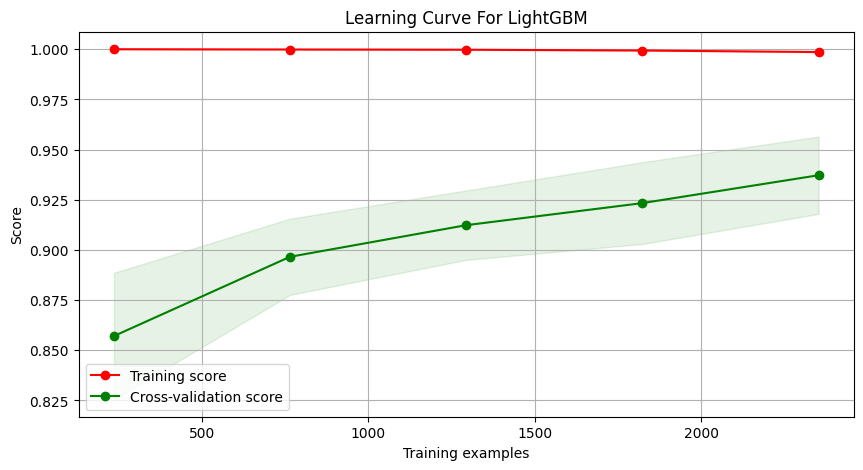

In [61]:
plot_learning_curve(best_model, 'Learning Curve For LightGBM', X_out_train, y_out_train, None, 10)
plt.savefig('7')
plt.show()

## Perbanding Sebelum dan Sesudah Tuning

### Sebelum Tuning

In [62]:
print('classification_report before tuning:\n',classification_report(y_out_test,final_pipe.predict(X_out_test)))
print('ROC-AUC:', roc_auc_score(y_out_test,final_pipe.predict(X_out_test)))

classification_report before tuning:
               precision    recall  f1-score   support

           0       0.98      0.93      0.95       547
           1       0.72      0.88      0.79       107

    accuracy                           0.92       654
   macro avg       0.85      0.91      0.87       654
weighted avg       0.93      0.92      0.93       654

ROC-AUC: 0.9054314954979582


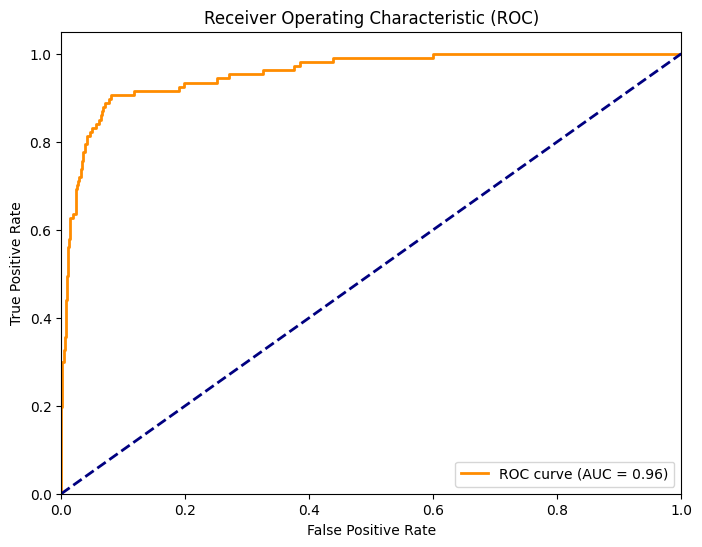

In [63]:
y_pred_proba = final_pipe.predict_proba(X_out_test)[:, 1]  # Probabilitas kelas positif

fpr, tpr, thresholds = roc_curve(y_out_test, y_pred_proba)
roc_auc = roc_auc_score(y_out_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

<Axes: >

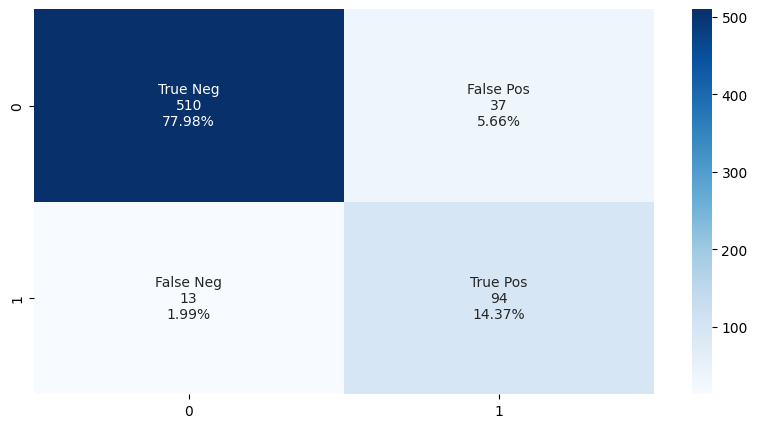

In [64]:
z=confusion_matrix(y_out_test,final_pipe.predict(X_out_test))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                z.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     z.flatten()/np.sum(z)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(10, 5))
sns.heatmap(z, annot=labels, fmt='', cmap='Blues')

### Sesudah Tuning

In [65]:
print('classification_report after tuning:\n',classification_report(y_out_test,best_model.predict(X_out_test)))
print('ROC-AUC', roc_auc_score(y_out_test, best_model.predict(X_out_test)))

classification_report after tuning:
               precision    recall  f1-score   support

           0       0.98      0.93      0.95       547
           1       0.70      0.90      0.79       107

    accuracy                           0.92       654
   macro avg       0.84      0.91      0.87       654
weighted avg       0.93      0.92      0.92       654

ROC-AUC 0.9111209827606828


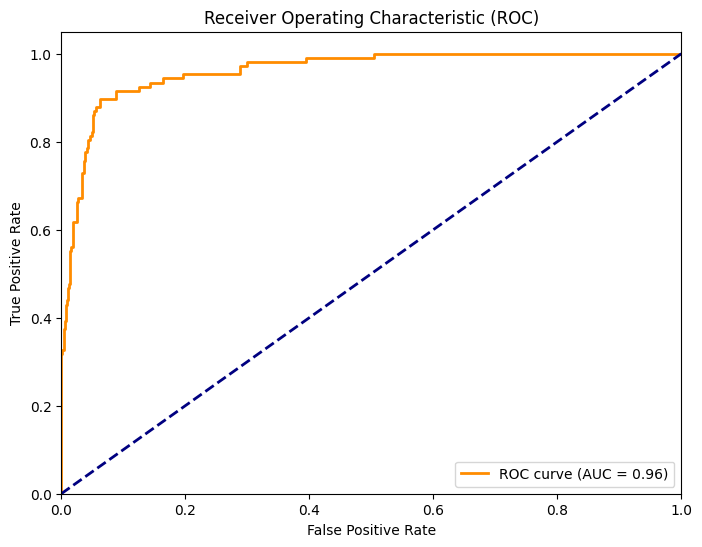

In [66]:
y_pred_proba = best_model.predict_proba(X_out_test)[:, 1]  # Probabilitas kelas positif

fpr, tpr, thresholds = roc_curve(y_out_test, y_pred_proba)
roc_auc = roc_auc_score(y_out_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

<Axes: >

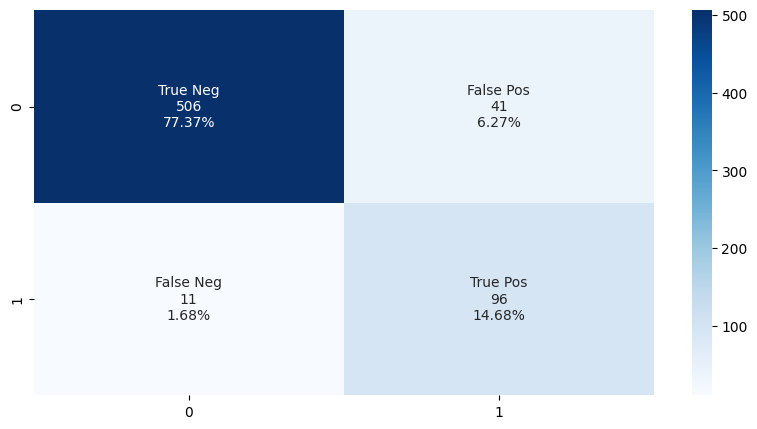

In [67]:
z=confusion_matrix(y_out_test,best_model.predict(X_out_test))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                z.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     z.flatten()/np.sum(z)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(10, 5))
sns.heatmap(z, annot=labels, fmt='', cmap='Blues')

Dapat kita lihat bahwa sebelum dan setelah tuning terdapat perbedaan yaitu:

1. Nilai Testing ROC-AUC mengalami kenaikan dari 90,1% menjadi 91,1%, dalam hal ini berarti model semakin baik dalam memisahkan kelas 0 (Negatif Churn) dan 1 (Positif Churn).
2. Pada confusion matrix-nya FN mengalami penurunan dari 13 menjadi 11, namun pada FP mengalami peningkatan dari 37 ke 41. Dalam metriks ini, positif adalah pelanggan yang akan churn, maka hal ini berarti terjadi penurunan potensi pelanggan yang luput dari pengawasan kita karena berdasarkan analisa mereka kita anggap sebagai pelanggan tidak churn, tapi pada kenyataannya adalah mereka akan churn (False Negative). Namun kemungkinan promosi sia-sia akan sedikit bertambah (False Positive).

Dalam keseluruhan, penyetelan model tampaknya membantu meningkatkan performa dalam mengidentifikasi kelas 1 (1) dengan meningkatkan recall tanpa mengorbankan terlalu banyak precision. Meskipun precision untuk kelas 1 sedikit berkurang, nilai recall yang lebih tinggi akan membantu model mengidentifikasi lebih banyak sampel positif, yaitu kelas yang lebih penting dalam kasus ini. Model juga tetap sangat baik dalam memprediksi kelas 0. Dengan demikian, penyetelan model tampaknya menghasilkan perbaikan dalam kasus ini.

# Feature Importance

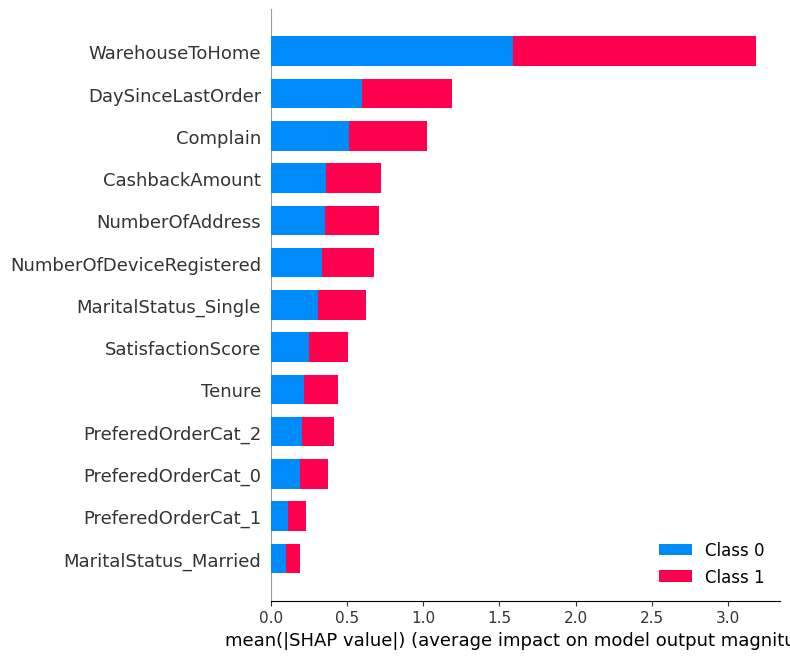

In [69]:
model = Pipeline([('preprocessing', transformer),
                  ('balancing', ros),
                  ('model',LGBMClassifier(random_state=1004, verbosity=0))])
model.fit(X_out_train, y_out_train)
X_train_transformed = model.named_steps['preprocessing'].transform(X_out_train)
all_varname = list(transformer.transformers_[0][1].get_feature_names_out()) + list(transformer.transformers_[1][1].get_feature_names_out())+ ['Tenure','WarehouseToHome','NumberOfDeviceRegistered','SatisfactionScore','NumberOfAddress','Complain', 'DaySinceLastOrder', 'CashbackAmount']
X_train_transformed = pd.DataFrame(X_train_transformed, columns=all_varname)
X_test_transformed = model.named_steps['preprocessing'].transform(X_out_test)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=all_varname)

shap_model = model.named_steps['model'].fit(X_train_transformed, y_out_train)
explainer = shap.TreeExplainer(shap_model)
shap_values = explainer.shap_values(X_test_transformed)
shap.summary_plot(shap_values, X_test_transformed, plot_type="bar")

Dapat kita lihat, di sini **Tenure** merupakan fitur terpenting dalam mengklasifikasikan positif dan negatif. Selain itu ada kolom **Complain**, **NumberOfAddress** dan **Complain** untuk selanjutnya kita akan masuk ke tahap rekomendasi dan konklusi.

## Insight

### 1. Tenure

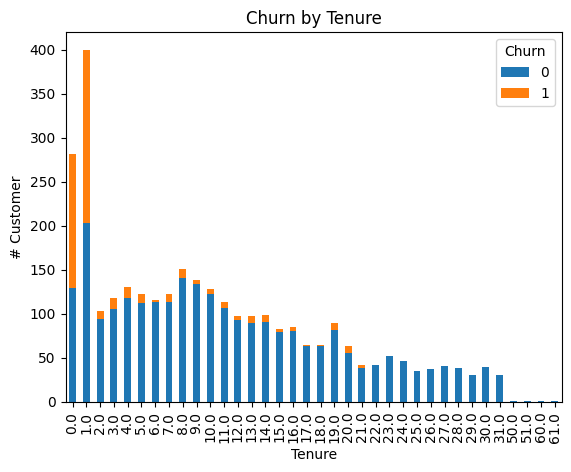

In [70]:
int_churn_contingency = pd.crosstab(df2["Tenure"], df2["Churn"])
int_churn_contingency.plot(kind = 'bar', stacked = 'true', title = "Churn by Tenure")
int_churn_contingency
plt.xlabel('Tenure')
plt.ylabel('# Customer')
plt.show()

Dapat kita lihat bahwa rasio Churn amat sangat dipengaruhi oleh masa Tenure, konsumen dalam masa langganan 2 bulan pertama berpotensi dalam menghasilkan churn paling besar.

### 2. Complain

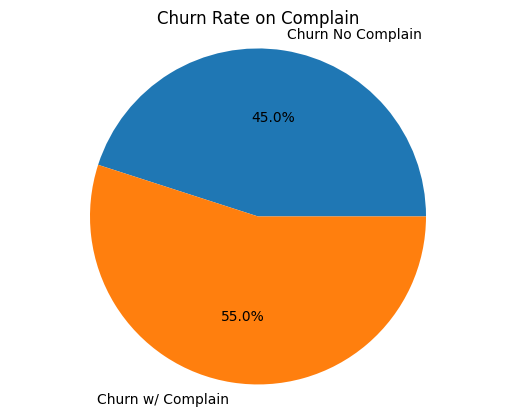

In [71]:
labels = ['Churn No Complain','Churn w/ Complain']
sizes = [
    len(df2[(df2['Complain'] == 0) & (df2['Churn']==1)]),
    len(df2[(df2['Complain'] == 1) & (df2['Churn']==1)])
]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Churn Rate on Complain')
plt.show()

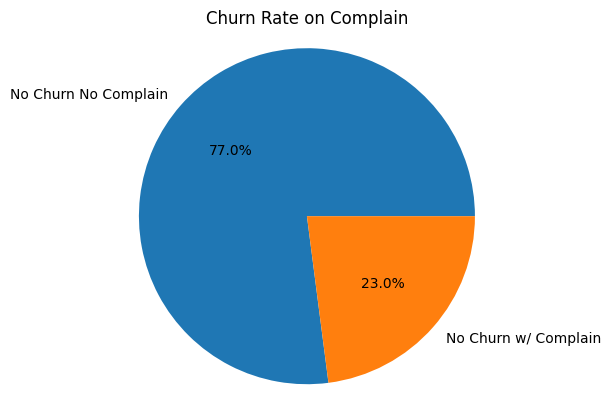

In [72]:
labels = ['No Churn No Complain','No Churn w/ Complain']
sizes = [
    len(df2[(df2['Complain'] == 0) & (df2['Churn']==0)]),
    len(df2[(df2['Complain'] == 1) & (df2['Churn']==0)])
]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Churn Rate on Complain')
plt.show()

In [73]:
group_by_complain = df2.groupby(['PreferedOrderCat','Complain']).size().reset_index()
group_by_complain['Complain'] = group_by_complain['Complain'].replace({1:'Complain',
                                                                0:'Not Complain'})

group_by_complain2 = df2.groupby(['PreferedOrderCat']).size().reset_index()
group_by_complain3 = group_by_complain.merge(group_by_complain2, how='left',
              on='PreferedOrderCat')

group_by_complain3.columns = ['PreferedOrderCat','Complain','Num_Customer','AllCustomer']
group_by_complain3['Ratio'] = (group_by_complain3['Num_Customer'] / group_by_complain3['AllCustomer'] * 100.0).round(2)
group_by_complain3

,PreferedOrderCat,Complain,Num_Customer,AllCustomer,Ratio
0,Fashion,Not Complain,344,484,71.07
1,Fashion,Complain,140,484,28.93
2,Grocery,Not Complain,169,241,70.12
3,Grocery,Complain,72,241,29.88
4,Laptop & Accessory,Not Complain,889,1213,73.29
5,Laptop & Accessory,Complain,324,1213,26.71
6,Mobile Phone,Not Complain,832,1182,70.39
7,Mobile Phone,Complain,350,1182,29.61
8,Others,Not Complain,114,149,76.51
9,Others,Complain,35,149,23.49


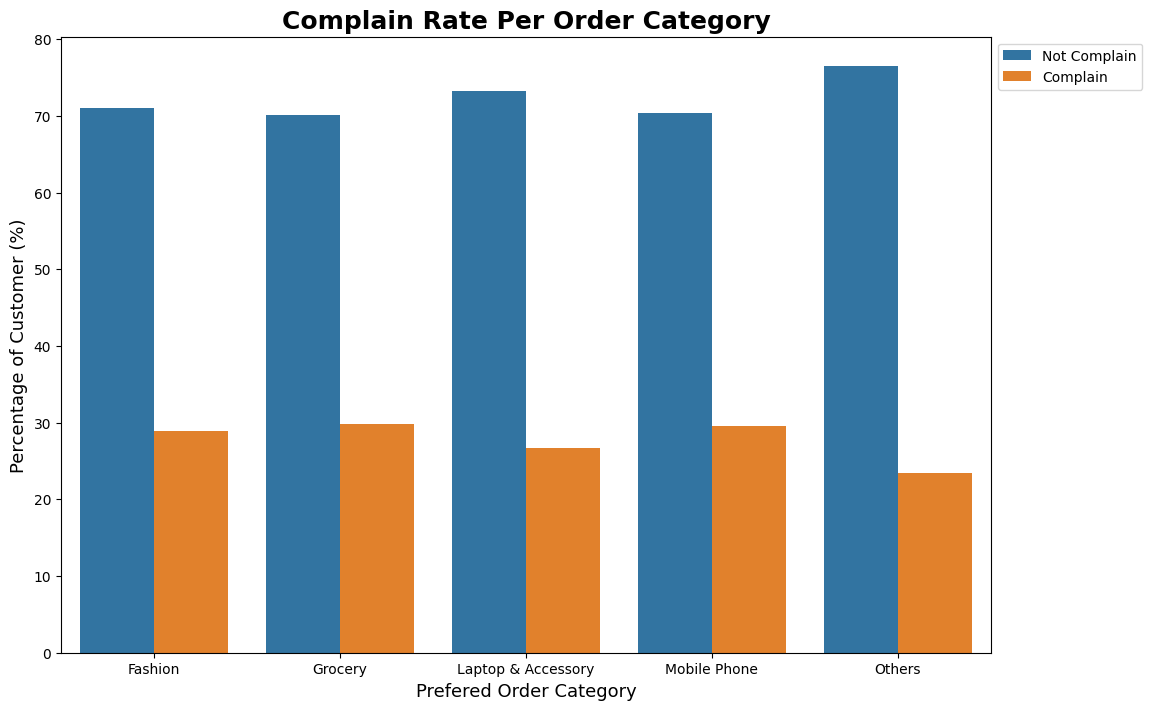

In [74]:
plt.figure(figsize=(12,8))
ax = sns.barplot(data=group_by_complain3, x='PreferedOrderCat', y='Ratio', hue='Complain')
plt.title('Complain Rate Per Order Category', color='black',fontsize=18,fontweight='bold')
plt.legend(loc='upper left',bbox_to_anchor=(1,1),ncol=1)
plt.xlabel('Prefered Order Category',fontsize=13)
plt.ylabel('Percentage of Customer (%)',fontsize=13)
plt.tick_params(axis = 'both', which = 'major', labelsize = 10)
plt.show()

Disini dapat kita lihat bahwa complain rate dalam suatu order category adalah hampir merata. Dan perbandingan antara konsumen komplain yang melakukan churn (55%) dan tidak churn (23%) adalah hampir dua kali lipatnya. 

### 3. Number Of Address

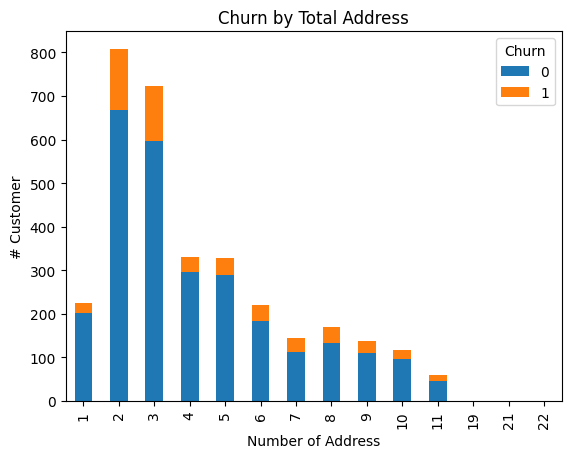

In [75]:
address_churn_cont = pd.crosstab(df2["NumberOfAddress"], df2["Churn"])
address_churn_cont.plot(kind = 'bar', stacked = 'true', title = "Churn by Total Address")
address_churn_cont
plt.xlabel('Number of Address')
plt.ylabel('# Customer')
plt.show()

Dalam posisi ketiga number of feature importance adalah kolom NumberOfAddress. Dapat kita simpulkan bahwa konsumen dengan jumlah address 2 dan 3 adalah yang paling berpotensi untuk melakukan Churn.

# Conclusion & Recommendation

Berdasarkan hasil classification report dari model yang memberikan kinerja terbaik, skor ROC-AUC terbaik jatuh pada algoritma LightGBM setelah dilakukan handling imbalance menggunakan Random Oversampler setelah dilakukan hyperparameter tuning. Dapat disimpulkan bahwa untuk model yang digunakan untuk memprediksi pelanggan mana saja yang berpotensi untuk *Churn* ke aplikasi perusahaan lain, **model yang terpilih dapat mengurangi 91,1% kandidat pelanggan yang akan benar-benar Churn karena sebelum pelanggan tersebut churn perusahaan dapat memberikan treatment untuk mencegah pelanggan tersebut Churn**.

Berdasarkan hasil laporan klasifikasi yang tadi kita buat. Apabila kita menganggap biaya promosi per pelanggan adalah 15 USD, dan Revenue rata-rata perpelanggan yang dihasilkan perusahaan adalah 100 USD. Dan kita berasumsi bahwa pelanggan berpotensi churn dapat kita gagalkan dengan biaya promosi. Maka perhitungan keuntungannya adalah:

* Revenue Dari Pelanggan Negatif Churn TN + FP (506+41) = 547 x 100 = 54,700 USD
* Revenue Dari Pelanggan Berpotensi Positif Churn (96 Orang) = (96 x 100) - (96 x 15) = 8,160 USD
* Loss dari promosi yang salah sasaran FP (41 Orang) = 41 x 15 = 615 USD
* Loss revenue dari pelanggan churn karena salah identifikasi (11 Orang) = 11 x 100 = 1,100 USD

**Keuntungan Menggunakan ML = 61,145 USD**

Apabila dibandingkan tanpa menggunakan ML 

* Revenue dari pelanggan tidak churn (547 Orang) = 54,700 USD

Namun karena tanpa menggunakan algoritma kita tidak akan bisa mendeteksi mana pelanggan yang akan positif churn, maka promosi akan dilakukan kepada seluruh pelanggan yang berjumlah 654 orang. Maka potensi pendapatannya adalah:

**54,700 - (654 x 15) = 44,890 USD**

Dengan demikian, karena adanya ML perusahaan berpotensi mendapatkan income **30,66% Lebih Besar** apabila menggunakan ML dalam mendeteksi potensi pelanggan churn.

**Rekomendasi**:

1. Menambahkan kolom ID untuk customer agar dapat membedakan mana data yang benar-benar duplikat mana data yang terlihat sama tapi sebenarnya berbeda agar sistem dapat memprediksi lebih akurat.
2. Menambahkan lebih banyak kolom dan jumlah baris data untuk mendukung pembelajaran model machine learning.

Untuk Strategi dalam menjaga kostumer tidak churn adalah:

1. **Membuat Membership Khusus**. Membuat tingkatan membership terhadap konsumen seperti *silver, gold, platinum* sehingga konsumen yang loyal mendapat poin lebih dan akan merasa menjadi bagian dari layanan. Ini juga memudahkan perusahaan untuk memberikan diskon, promo, dan *privilege* khusus terhadap konsumen yang loyal. Dan hal ini juga bisa ditambahkan ke dalam data untuk jadi salah satu bahan pembelajaran machine learning.
2. **Memberikan Reward/Hadiah**. Dalam setiap bertransaksi konsumen dapat diberikan poin yang bisa ditukar dengan hadiah bisa berupa barang, kupon, atau penawaran istimewa lainnya. Hal ini berguna untuk menstimulasi kostumer terus menerus bertransaksi menggunakan layanan.
3. **Memberikan promo diskon / cashback**. Pemberian promo berupa diskon atau cashback mampu memberikan ketertarikan pelanggan agar terus berlangganan dan bertransaksi, namun langkah ini juga harus dianalisis lebih dalam untuk jumlah dan periode waktunya karena dapat berdampak buruk juga jika perusahaan terlalu berlebihan dalam melakukannya.  
4. **Meningkatkan dukungan konsumen**. Ketika customer mendapatkan dukungan dan arahan penuh dari perusahaan, maka customer lebih mungkin untuk tidak melakukan churn. Misalnya seperti dukungan via telepon, text, video tutorial, in-app customer service, atau blog yang membantu. Dukungan ini memberikan kesan perlindungan dan perhatian lebih terhadap customer sehingga mencegah costumer berpindah ke kompetitor.   
5. **Monitor Kompetitor**. Analisis kompetitor dan lihat kembali layanan mana yang bisa ditingkatkan lebih baik dari kompetitor. 
6. **Memperhatikan feedback**. Perhatikan feedback yang didapat dari customer baik yang positif maupun negatif. 
7. **Meningkatkan Layanan Tambahan**. 2 Bulan pertama merupakan masa paling krusial untuk menjaga customer tetap loyal. Hal ini karena pengguna cenderung churn pada 2 bulan pertama penggunaan. Sehingga untuk mengantisipasi hal tersebut, lebih baik customer diberikan layanan tambahan, seperti UX yang baik, hadiah untuk pembelian pertama, ataupun pemberian diskon eksklusif untuk pelanggan pertama.